# Prediccion de la Floracion de Cerezos

## Objetivo
Predecir el dia del año (DOY) en el que comienza la floracion de cerezos utilizando datos climaticos, geograficos y botanicos.

## Indice
1. Importacion de librerias
2. Exploracion inicial de datos
3. Tratamiento de datos
4. Analisis exploratorio de datos (EDA)
5. Transformacion y preparacion de datos
6. Modelado
7. Evaluacion de modelos
8. Conclusiones

## 1. Importacion de Librerias

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 1b. Carga de Datos

In [191]:
from pathlib import Path
import pandas as pd

# Intentar múltiples ubicaciones relativas
def find_dataset():
    """Busca el dataset en ubicaciones relativas comunes."""
    candidates = [
        Path("data/dataset_final.csv"),
        Path("../data/dataset_final.csv"),
        Path("./dataset_final.csv"),
        Path(__file__).parent / "data" / "dataset_final.csv" if '__file__' in dir() else None,
    ]
    
    for path in candidates:
        if path and path.exists():
            return path
    
    raise FileNotFoundError(
        "No se encontró dataset_final.csv. "
        "Asegúrate de que el archivo esté en una de estas ubicaciones:\n"
        + "\n".join([f"  - {p}" for p in candidates if p])
    )

# Cargar datos
csv_path = find_dataset()
df = pd.read_csv(csv_path, index_col=0)
df.columns = [c.strip().replace('\xa0', ' ').strip() for c in df.columns]

print(f"✅ Dataset cargado desde: {csv_path}")
print(f"   Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")

✅ Dataset cargado desde: data\dataset_final.csv
   Dimensiones: 10961 filas, 28 columnas


## 2. Exploracion Inicial de Datos

In [192]:
print("Estructura del dataset:")
print(f"Dimensiones: {df.shape}")
print(f"\nTipos de datos:\n{df.dtypes.value_counts()}")

Estructura del dataset:
Dimensiones: (10961, 28)

Tipos de datos:
float64    19
object      5
int64       4
Name: count, dtype: int64


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10961 entries, France to Norway
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Institute                      10961 non-null  object 
 1   Site                           10961 non-null  object 
 2   Latitude                       10961 non-null  float64
 3   Longitude                      10961 non-null  float64
 4   Altitude                       10961 non-null  int64  
 5   Plantation                     8906 non-null   float64
 6   Year                           10961 non-null  int64  
 7   Cultivar                       10961 non-null  object 
 8   Clone                          8794 non-null   object 
 9   Rootstock                      1095 non-null   object 
 10  Beginning.of.flowering.(date)  10780 non-null  float64
 11  Full.Flowering.(date)          10089 non-null  float64
 12  End.of.flowering.(date)        10107 non-null

In [194]:
print("Informacion detallada de columnas:")
col_info = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.values,
    'Nulls': df.isnull().sum().values,
    '% Nulls': (df.isnull().sum() / len(df) * 100).values
})
col_info = col_info.sort_values('% Nulls', ascending=False)
print(col_info.to_string(index=False))

Informacion detallada de columnas:
                       Column    Type  Nulls   % Nulls
                    Rootstock  object   9866 90.010036
 Beginning.of.Maturity.(date) float64   3690 33.664812
        Beginning.of.Maturity float64   3349 30.553782
                        Clone  object   2167 19.770094
                   Plantation float64   2055 18.748289
             End.of.flowering float64   2031 18.529331
        Full.Flowering.(date) float64    872  7.955479
               Full.Flowering float64    854  7.791260
      End.of.flowering.(date) float64    854  7.791260
           Flowering.duration float64    846  7.718274
Beginning.of.flowering.(date) float64    181  1.651309
                    gdd_total float64      0  0.000000
               temp_media_30d float64      0  0.000000
                 temp_max_30d float64      0  0.000000
             frost_days_total float64      0  0.000000
                 temp_min_30d float64      0  0.000000
                 precip_total 

In [195]:
print("Estadisticas descriptivas de variables numericas:")
df.describe().T

Estadisticas descriptivas de variables numericas:


,count,mean,std,min,25%,50%,75%,max
Latitude,10961.0,45.225677,3.487211,38.040000,43.760000,44.580000,44.820000,60.320000
Longitude,10961.0,3.626974,4.750893,-5.950000,-0.280000,4.460000,4.890000,24.700000
Altitude,10961.0,67.818903,93.372061,-1.000000,8.000000,38.000000,134.000000,536.000000
Plantation,8906.0,1994.605098,7.567181,1978.000000,1990.000000,1995.000000,2001.000000,2013.000000
Year,10961.0,2000.372411,7.740628,1984.000000,1994.000000,2001.000000,2007.000000,2015.000000
Beginning.of.flowering.(date),10780.0,40276.782576,2778.037620,30779.000000,41352.000000,41361.000000,41368.000000,42504.000000
Full.Flowering.(date),10089.0,40682.065220,2135.191767,30797.000000,41359.000000,41367.000000,41375.000000,42510.000000
End.of.flowering.(date),10107.0,40255.850401,2827.512085,30792.000000,41365.000000,41374.000000,41382.000000,42521.000000
Beginning.of.Maturity.(date),7271.0,40963.208775,2138.345598,30829.000000,41421.000000,41432.000000,41442.000000,42602.000000
Beginning.of.flowering,10961.0,90.818265,11.751929,47.000000,83.000000,89.000000,97.000000,142.000000


In [196]:
print("Analisis de variables categoricas:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} valores unicos")
    print(df[col].value_counts().head(10))

Analisis de variables categoricas:

Institute: 18 valores unicos
Institute
INRA        4056
Ctifl       2523
Sefra       1814
OVA          685
FRI          338
Serfel       325
IMIDA        234
Bioforsk     231
IRTA         172
EMR          157
Name: count, dtype: int64

Site: 21 valores unicos
Site
Toulenne        4056
Balandran       2523
Etoile          1675
Jork             685
Čačak            338
St Gilles        325
Jumilla          234
Ullensvang       231
Corbins          157
East Malling     157
Name: count, dtype: int64

Cultivar: 194 valores unicos
Cultivar
Burlat                771
Summit                485
Van                   338
Sweetheart Sumtare    323
Stark Hardy Giant     273
Rainier               256
Hedelfingen           242
Duroni 3              236
Lapins                186
Sunburst              180
Name: count, dtype: int64

Clone: 409 valores unicos
Clone
V370     555
V2017    414
V1927    229
V1903    209
V1877    198
V2472    192
V3502    185
V1378    147
V

Analisis de variable objetivo: Beginning.of.flowering

Interpretacion: DOY (Day of Year) - dia del año (1-365)
Valores nulos: 0

Estadisticas:
count    10961.000000
mean        90.818265
std         11.751929
min         47.000000
25%         83.000000
50%         89.000000
75%         97.000000
max        142.000000
Name: Beginning.of.flowering, dtype: float64


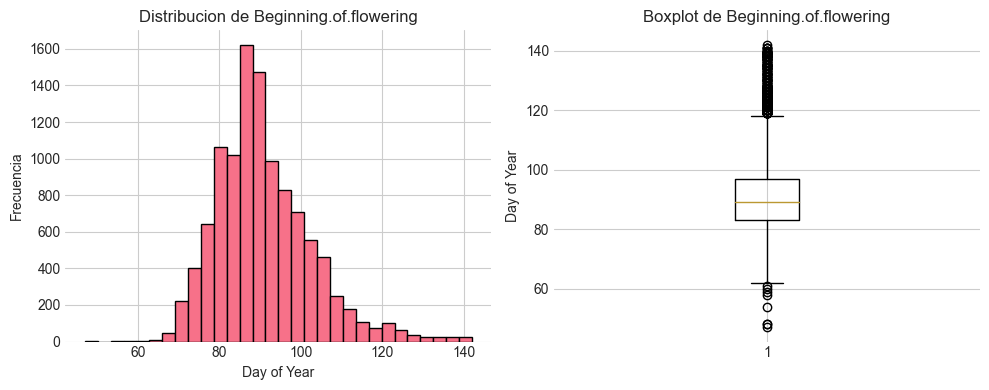

In [197]:
print("Analisis de variable objetivo: Beginning.of.flowering")
print(f"\nInterpretacion: DOY (Day of Year) - dia del año (1-365)")
print(f"Valores nulos: {df['Beginning.of.flowering'].isnull().sum()}")
print(f"\nEstadisticas:")
print(df['Beginning.of.flowering'].describe())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Beginning.of.flowering'].dropna(), bins=30, edgecolor='black')
plt.xlabel('Day of Year')
plt.ylabel('Frecuencia')
plt.title('Distribucion de Beginning.of.flowering')

plt.subplot(1, 2, 2)
plt.boxplot(df['Beginning.of.flowering'].dropna())
plt.ylabel('Day of Year')
plt.title('Boxplot de Beginning.of.flowering')

plt.tight_layout()
plt.show()

## 3. Tratamiento de Datos

### 3a. Visualizacion de Valores Nulos

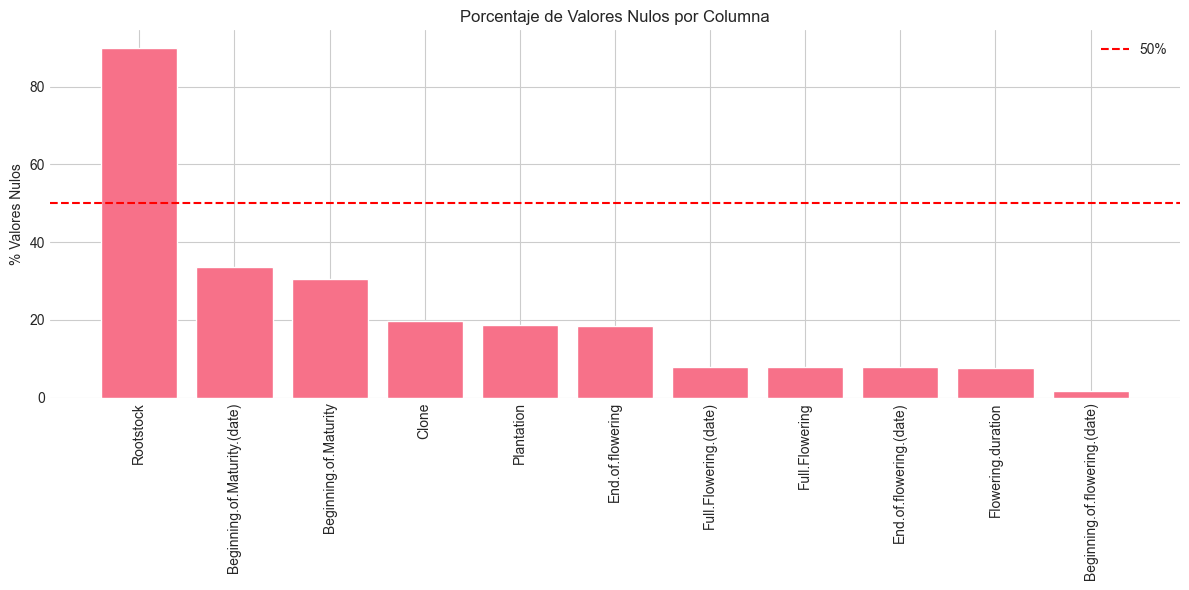

In [198]:
null_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
null_pct = null_pct[null_pct > 0]

plt.figure(figsize=(12, 6))
plt.bar(range(len(null_pct)), null_pct.values)
plt.xticks(range(len(null_pct)), null_pct.index, rotation=90)
plt.ylabel('% Valores Nulos')
plt.title('Porcentaje de Valores Nulos por Columna')
plt.axhline(y=50, color='r', linestyle='--', label='50%')
plt.legend()
plt.tight_layout()
plt.show()

### 3b. Eliminacion de Columnas

In [199]:
print("Eliminando columnas:")
print("- Columnas de fecha (redundantes con DOY)")
print("- Rootstock (88% valores nulos)")
print("- Columnas de leakage (Full.Flowering, End.of.flowering, Beginning.of.Maturity, Flowering.duration)")

cols_to_drop = [
    'Beginning.of.flowering.(date)',  # redundante con Beginning.of.flowering (DOY)
    'Full.Flowering.(date)',          # redundante + leakage
    'End.of.flowering.(date)',        # redundante + leakage
    'Beginning.of.Maturity.(date)',   # redundante + leakage
    'Rootstock',                      # 88% nulos
    'Full.Flowering',                 # leakage: ocurre despues del inicio de floracion
    'End.of.flowering',               # leakage
    'Beginning.of.Maturity',          # leakage
    'Flowering.duration' ,
                 "  Clone  " ,
                            'Institute'           # leakage
]

cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop)

print(f"\nColumnas eliminadas: {len(cols_to_drop)}")
for c in cols_to_drop:
    print(f"  - {c}")
print(f"\nDimensiones actuales: {df.shape}")

Eliminando columnas:
- Columnas de fecha (redundantes con DOY)
- Rootstock (88% valores nulos)
- Columnas de leakage (Full.Flowering, End.of.flowering, Beginning.of.Maturity, Flowering.duration)

Columnas eliminadas: 10
  - Beginning.of.flowering.(date)
  - Full.Flowering.(date)
  - End.of.flowering.(date)
  - Beginning.of.Maturity.(date)
  - Rootstock
  - Full.Flowering
  - End.of.flowering
  - Beginning.of.Maturity
  - Flowering.duration
  - Institute

Dimensiones actuales: (10961, 18)


quedarme solo con los cultivares con mas de 

In [200]:
# print("Filtrado: Solo cultivares con más de 10 observaciones por sitio")

# # Contar observaciones por combinación Site-Cultivar
# site_cultivar_counts = df.groupby(['Site', 'Cultivar']).size()
# print(f"\nTotal de combinaciones Site-Cultivar antes del filtro: {len(site_cultivar_counts)}")

# # Filtrar combinaciones con más de 10 observaciones
# valid_combinations = site_cultivar_counts[site_cultivar_counts > 10]
# print(f"Combinaciones con más de 10 observaciones: {len(valid_combinations)}")

# # Crear máscara para filtrar el dataset
# mask = df.apply(lambda row: (row['Site'], row['Cultivar']) in valid_combinations.index, axis=1)

# # Aplicar filtro
# df = df[mask].copy()

# print(f"\nDimensiones después del filtro: {df.shape}")
# print(f"Reducción: {mask.sum() - len(mask)} filas ({((len(mask) - mask.sum()) / len(mask) * 100):.1f}%)")

# # Mostrar estadísticas del filtrado
# print(f"\nSitios únicos restantes: {df['Site'].nunique()}")
# print(f"Cultivares únicos restantes: {df['Cultivar'].nunique()}")

# # Top 10 combinaciones más frecuentes
# print(f"\nTop 10 combinaciones Site-Cultivar más frecuentes:")
# top_combinations = df.groupby(['Site', 'Cultivar']).size().sort_values(ascending=False)
# for (site, cultivar), count in top_combinations.items():
#     print(f"  {site} - {cultivar}: {count} observaciones")

### 3c. Imputacion Paso 1

In [201]:
print("Imputacion de Clone por moda del Site:")
if 'Clone' in df.columns and 'Site' in df.columns:
    null_clone_before = df['Clone'].isnull().sum()
    df['Clone'] = df.groupby('Site')['Clone'].transform(
        lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Desconocido')
    )
    # Rellenar los que queden (sites sin moda)
    df['Clone'] = df['Clone'].fillna('Desconocido')
    null_clone_after = df['Clone'].isnull().sum()
    print(f"Valores nulos en Clone: {null_clone_before} -> {null_clone_after}")

print("\nEliminando filas con valores nulos en variables climaticas (solo 6 filas, 0.05%):")
climate_null_cols = ['dynamic_chill_total', 'temp_media_30d', 'temp_max_30d', 'temp_min_30d']

rows_before = len(df)
df = df.dropna(subset=climate_null_cols)
rows_after = len(df)

print(f"Filas eliminadas: {rows_before - rows_after}")
print(f"Dimensiones actuales: {df.shape}")

Imputacion de Clone por moda del Site:
Valores nulos en Clone: 2167 -> 0

Eliminando filas con valores nulos en variables climaticas (solo 6 filas, 0.05%):
Filas eliminadas: 0
Dimensiones actuales: (10961, 18)


### 3d. Comparacion de Metodos de Imputacion

Comparacion de metodos de imputacion para Plantation y rad_media:
Metodos: Mediana (baseline), KNN (k=5), IterativeImputer (LinearRegression)



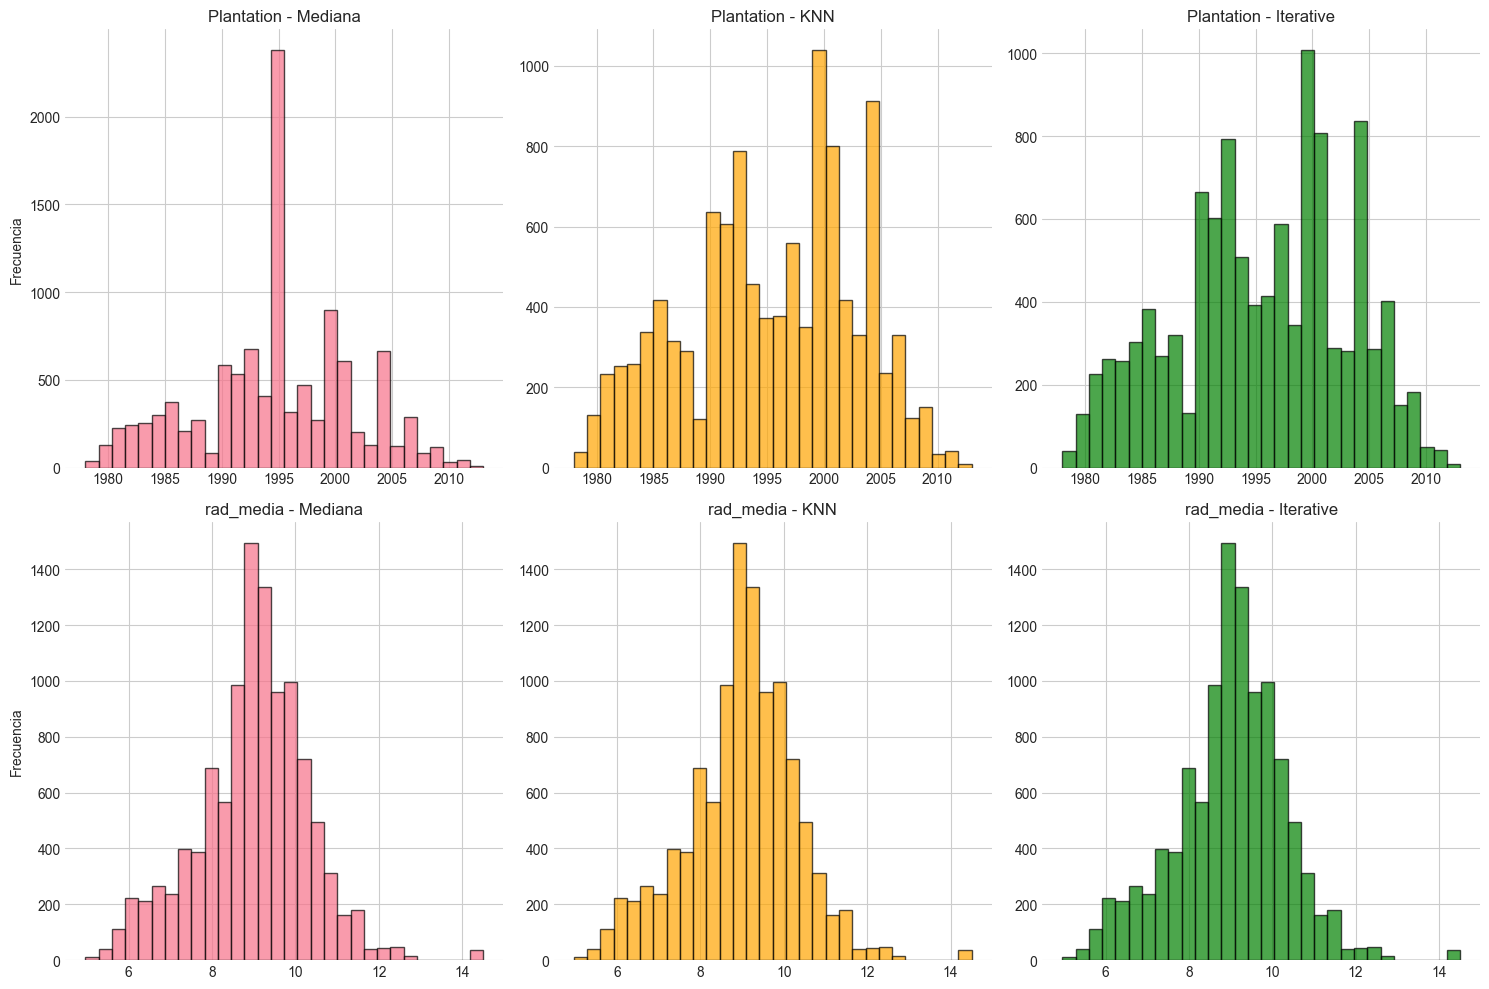


Estadisticas comparativas:
  Variable    Metodo       Media      Std         Min         Max
Plantation   Mediana 1994.679135 6.822706 1978.000000 2013.000000
Plantation       KNN 1995.332383 7.524716 1978.000000 2013.000000
Plantation Iterative 1995.420524 7.555021 1978.000000 2013.000000
 rad_media   Mediana    8.994986 1.322378    4.962316   14.505313
 rad_media       KNN    8.994986 1.322378    4.962316   14.505313
 rad_media Iterative    8.994986 1.322378    4.962316   14.505313


In [202]:
print("Comparacion de metodos de imputacion para Plantation y rad_media:")
print("Metodos: Mediana (baseline), KNN (k=5), IterativeImputer (LinearRegression)\n")

# Preparar datos
impute_cols = ['Plantation', 'rad_media']
impute_cols = [col for col in impute_cols if col in df.columns]

# Crear copias
df_median = df.copy()
df_knn = df.copy()
df_iter = df.copy()

# Metodo 1: Mediana
for col in impute_cols:
    if df_median[col].isnull().any():
        df_median[col] = df_median[col].fillna(df_median[col].median())

# Metodo 2: KNN
numeric_cols = df_knn.select_dtypes(include=[np.number]).columns.tolist()
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
df_knn[numeric_cols] = knn_imputer.fit_transform(df_knn[numeric_cols])

# Metodo 3: IterativeImputer
iter_imputer = IterativeImputer(estimator=LinearRegression(), random_state=42)
df_iter[numeric_cols] = iter_imputer.fit_transform(df_iter[numeric_cols])

# Visualizacion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(impute_cols):
    if col in df.columns:
        # Mediana
        axes[i, 0].hist(df_median[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i, 0].set_title(f'{col} - Mediana')
        axes[i, 0].set_ylabel('Frecuencia')
        
        # KNN
        axes[i, 1].hist(df_knn[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
        axes[i, 1].set_title(f'{col} - KNN')
        
        # Iterative
        axes[i, 2].hist(df_iter[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
        axes[i, 2].set_title(f'{col} - Iterative')

plt.tight_layout()
plt.show()

# Estadisticas
print("\nEstadisticas comparativas:")
stats_comparison = []
for col in impute_cols:
    if col in df.columns:
        stats_comparison.append({
            'Variable': col,
            'Metodo': 'Mediana',
            'Media': df_median[col].mean(),
            'Std': df_median[col].std(),
            'Min': df_median[col].min(),
            'Max': df_median[col].max()
        })
        stats_comparison.append({
            'Variable': col,
            'Metodo': 'KNN',
            'Media': df_knn[col].mean(),
            'Std': df_knn[col].std(),
            'Min': df_knn[col].min(),
            'Max': df_knn[col].max()
        })
        stats_comparison.append({
            'Variable': col,
            'Metodo': 'Iterative',
            'Media': df_iter[col].mean(),
            'Std': df_iter[col].std(),
            'Min': df_iter[col].min(),
            'Max': df_iter[col].max()
        })

stats_df = pd.DataFrame(stats_comparison)
print(stats_df.to_string(index=False))

### 3e. Aplicacion de Imputacion KNN

In [203]:
print("Aplicando imputacion KNN a variables numericas con valores nulos:")
print("Razon: KNN preserva mejor la distribucion original y considera relaciones entre variables")
print("IMPORTANTE: Se excluye la variable objetivo para evitar data leakage\n")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluir target para que no influya en la imputacion de features
target_col = 'Beginning.of.flowering'
impute_cols = [c for c in numeric_cols if c != target_col]

knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
df[impute_cols] = knn_imputer.fit_transform(df[impute_cols])

print(f"Variables imputadas: {len(impute_cols)} (excluyendo {target_col})")
print(f"Total de valores nulos restantes: {df.isnull().sum().sum()}")
print("\nVerificacion por columna:")
remaining = df.isnull().sum()
remaining = remaining[remaining > 0]
if len(remaining) == 0:
    print("Sin valores nulos.")
else:
    print(remaining)

Aplicando imputacion KNN a variables numericas con valores nulos:
Razon: KNN preserva mejor la distribucion original y considera relaciones entre variables
IMPORTANTE: Se excluye la variable objetivo para evitar data leakage

Variables imputadas: 14 (excluyendo Beginning.of.flowering)
Total de valores nulos restantes: 0

Verificacion por columna:
Sin valores nulos.


### 3f. Deteccion de Outliers

In [204]:
print("Deteccion de outliers mediante metodo IQR:")
print("Outlier: valor < Q1 - 1.5*IQR o valor > Q3 + 1.5*IQR\n")

outlier_report = []
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(df)) * 100
    
    outlier_report.append({
        'Variable': col,
        'N_Outliers': n_outliers,
        '% Outliers': round(pct_outliers, 2),
        'Lower_Bound': round(lower_bound, 2),
        'Upper_Bound': round(upper_bound, 2)
    })

outlier_df = pd.DataFrame(outlier_report)
outlier_df = outlier_df.sort_values('% Outliers', ascending=False)
print(outlier_df.to_string(index=False))

Deteccion de outliers mediante metodo IQR:
Outlier: valor < Q1 - 1.5*IQR o valor > Q3 + 1.5*IQR

              Variable  N_Outliers  % Outliers  Lower_Bound  Upper_Bound
              Latitude        1730       15.78        42.17        46.41
          Cultivar_enc         771        7.03      -241.00       527.00
             Longitude         528        4.82        -8.04        12.64
   dynamic_chill_total         499        4.55        75.97       134.84
              Altitude         383        3.49      -181.00       323.00
          temp_max_30d         364        3.32         8.88        18.89
Beginning.of.flowering         338        3.08        62.00       118.00
          precip_total         314        2.86       -67.57       383.12
      frost_days_total         312        2.85       -19.50        80.50
        temp_media_30d         311        2.84         3.86        12.55
          temp_min_30d         302        2.76        -1.22         8.00
             rad_media     

### 3g. Tratamiento de Outliers - Winsorizing

Aplicando Winsorizing: Cap en percentil 1 y 99
Metodo: Reemplazar valores extremos con limites P1/P99 usando .clip()
IMPORTANTE: Se excluye la variable objetivo (Beginning.of.flowering)

Reduccion de outliers por variable:
           Variable  Outliers_Before  Outliers_After  Reduction
       temp_max_30d              220               0        220
          rad_media              220               0        220
dynamic_chill_total              215               0        215
       precip_total              210               0        210
     temp_media_30d              209               0        209
       temp_min_30d              201               0        201
   frost_days_total              198               0        198
               Year              189               0        189
         Plantation              128               0        128
          gdd_total              110               0        110
       Cultivar_enc               89               0         89
         

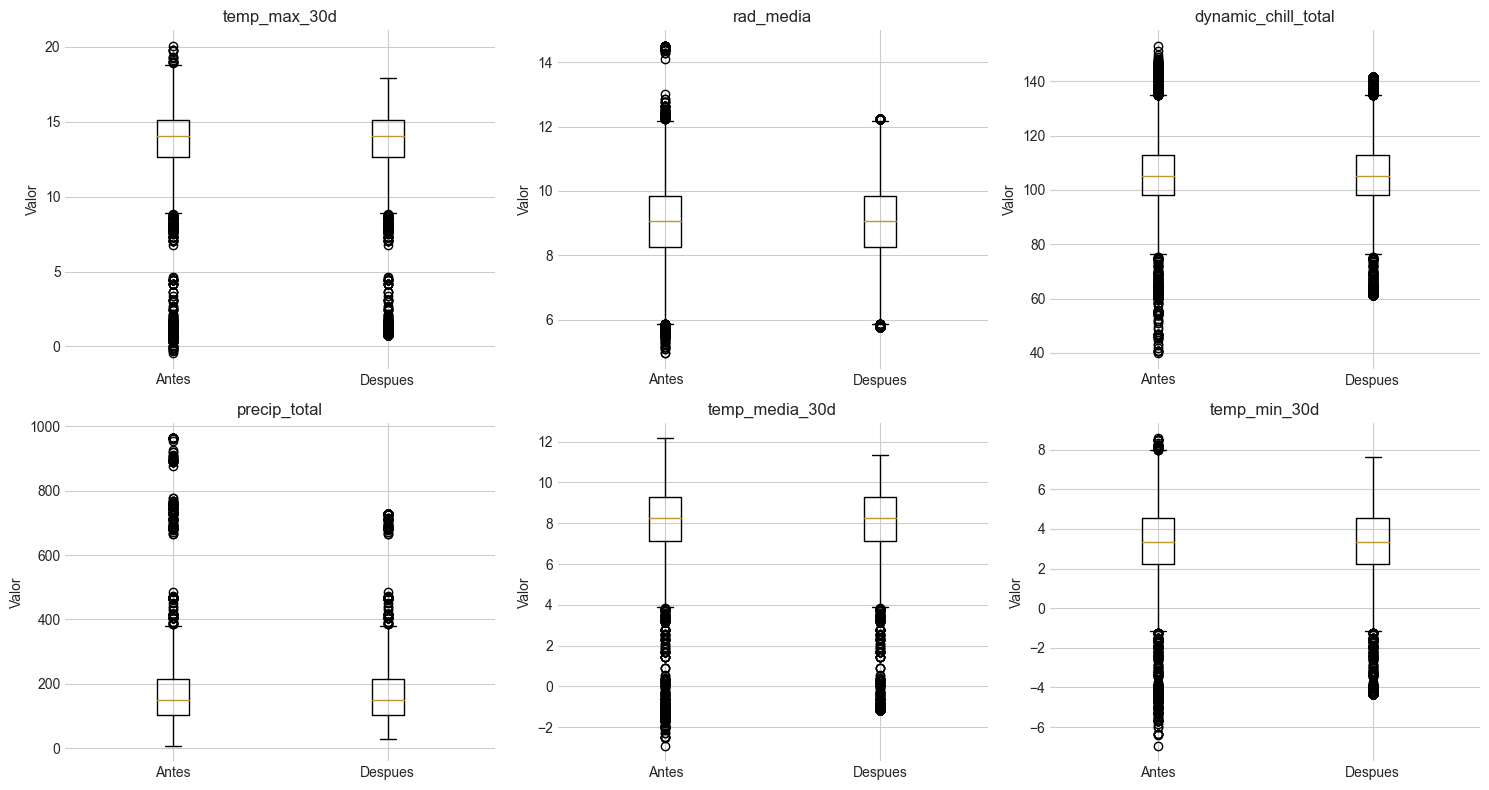

In [205]:
print("Aplicando Winsorizing: Cap en percentil 1 y 99")
print("Metodo: Reemplazar valores extremos con limites P1/P99 usando .clip()")
print("IMPORTANTE: Se excluye la variable objetivo (Beginning.of.flowering)\n")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = 'Beginning.of.flowering'
winsorize_cols = [c for c in numeric_cols if c != target_col]

df_before = df.copy()

winsorize_report = []
for col in winsorize_cols:
    p1 = df[col].quantile(0.01)
    p99 = df[col].quantile(0.99)
    
    outliers_before = ((df[col] < p1) | (df[col] > p99)).sum()
    df[col] = df[col].clip(lower=p1, upper=p99)
    outliers_after = ((df[col] < p1) | (df[col] > p99)).sum()
    
    winsorize_report.append({
        'Variable': col,
        'Outliers_Before': outliers_before,
        'Outliers_After': outliers_after,
        'Reduction': outliers_before - outliers_after
    })

# Tabla de reduccion
winsorize_df = pd.DataFrame(winsorize_report)
winsorize_df = winsorize_df[winsorize_df['Reduction'] > 0].sort_values('Reduction', ascending=False)
print("Reduccion de outliers por variable:")
print(winsorize_df.to_string(index=False))

# Visualizacion antes/despues (primeras 6 variables con mas reduccion)
top_vars = winsorize_df.head(6)['Variable'].tolist()
if len(top_vars) > 0:
    fig, axes = plt.subplots(2, min(3, len(top_vars)), figsize=(15, 8))
    axes = axes.flatten() if len(top_vars) > 1 else [axes]
    
    for i, col in enumerate(top_vars[:6]):
        if i < len(axes):
            axes[i].boxplot([df_before[col], df[col]], labels=['Antes', 'Despues'])
            axes[i].set_title(col)
            axes[i].set_ylabel('Valor')
    
    plt.tight_layout()
    plt.show()

## 4. Analisis Exploratorio de Datos (EDA)

In [206]:
print("Boxplot de Beginning.of.flowering por pais:")

if 'Country' in df.columns and 'Beginning.of.flowering' in df.columns:
    plt.figure(figsize=(12, 6))
    countries = df['Country'].value_counts().head(10).index
    df_plot = df[df['Country'].isin(countries)]
    
    sns.boxplot(data=df_plot, x='Country', y='Beginning.of.flowering', hue=None)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Pais')
    plt.ylabel('Day of Year')
    plt.title('Distribucion de Floracion por Pais (Top 10)')
    plt.tight_layout()
    plt.show()

Boxplot de Beginning.of.flowering por pais:


In [207]:
df.shape

(10961, 18)

Relacion entre variables climaticas y floracion:


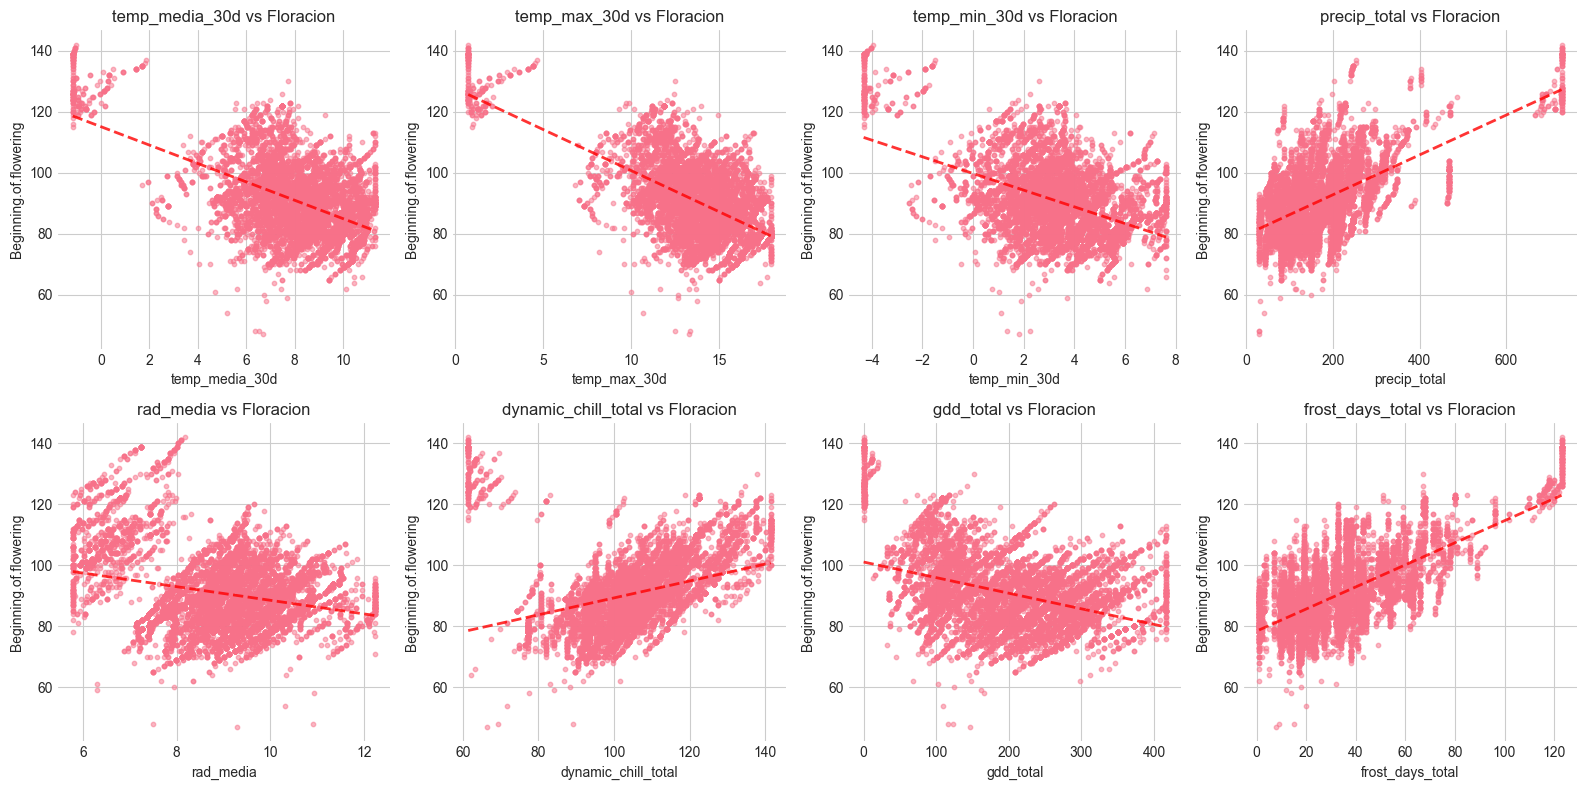

In [208]:
print("Relacion entre variables climaticas y floracion:")

climate_vars = ['temp_media_30d', 'temp_max_30d', 'temp_min_30d', 'precip_total', 
                'rad_media', 'dynamic_chill_total', 'gdd_total', 'frost_days_total']
climate_vars = [v for v in climate_vars if v in df.columns]

if 'Beginning.of.flowering' in df.columns and len(climate_vars) > 0:
    n_vars = len(climate_vars)
    n_cols = min(4, n_vars)
    n_rows = (n_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()
    
    for i, var in enumerate(climate_vars):
        axes[i].scatter(df[var], df['Beginning.of.flowering'], alpha=0.5, s=10)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Beginning.of.flowering')
        axes[i].set_title(f'{var} vs Floracion')
        
        # Linea de tendencia
        try:
            z = np.polyfit(df[var].values, df['Beginning.of.flowering'].values, 1)
            p = np.poly1d(z)
            x_sorted = np.sort(df[var].values)
            axes[i].plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2)
        except np.linalg.LinAlgError:
            pass
    
    # Ocultar ejes sobrantes
    for j in range(len(climate_vars), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Relacion entre variables geograficas y floracion:


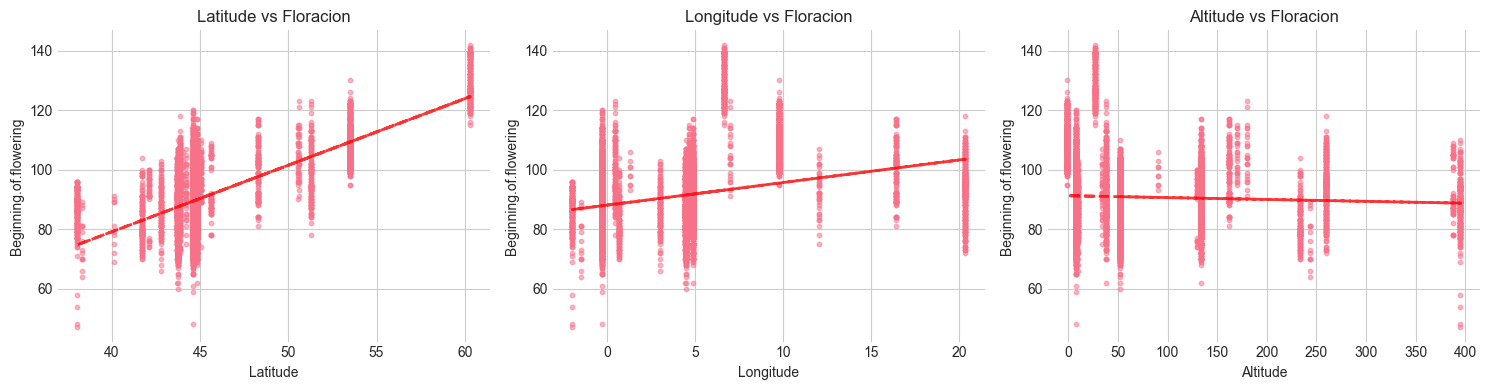

In [209]:
print("Relacion entre variables geograficas y floracion:")

geo_vars = ['Latitude', 'Longitude', 'Altitude']
geo_vars = [v for v in geo_vars if v in df.columns]

if 'Beginning.of.flowering' in df.columns and len(geo_vars) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, var in enumerate(geo_vars):
        axes[i].scatter(df[var], df['Beginning.of.flowering'], alpha=0.5, s=10)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Beginning.of.flowering')
        axes[i].set_title(f'{var} vs Floracion')
        
        # Linea de tendencia
        try:
            z = np.polyfit(df[var].values, df['Beginning.of.flowering'].values, 1)
            p = np.poly1d(z)
            axes[i].plot(df[var], p(df[var]), "r--", alpha=0.8, linewidth=2)
        except np.linalg.LinAlgError:
            pass
    
    plt.tight_layout()
    plt.show()

Matriz de correlacion:


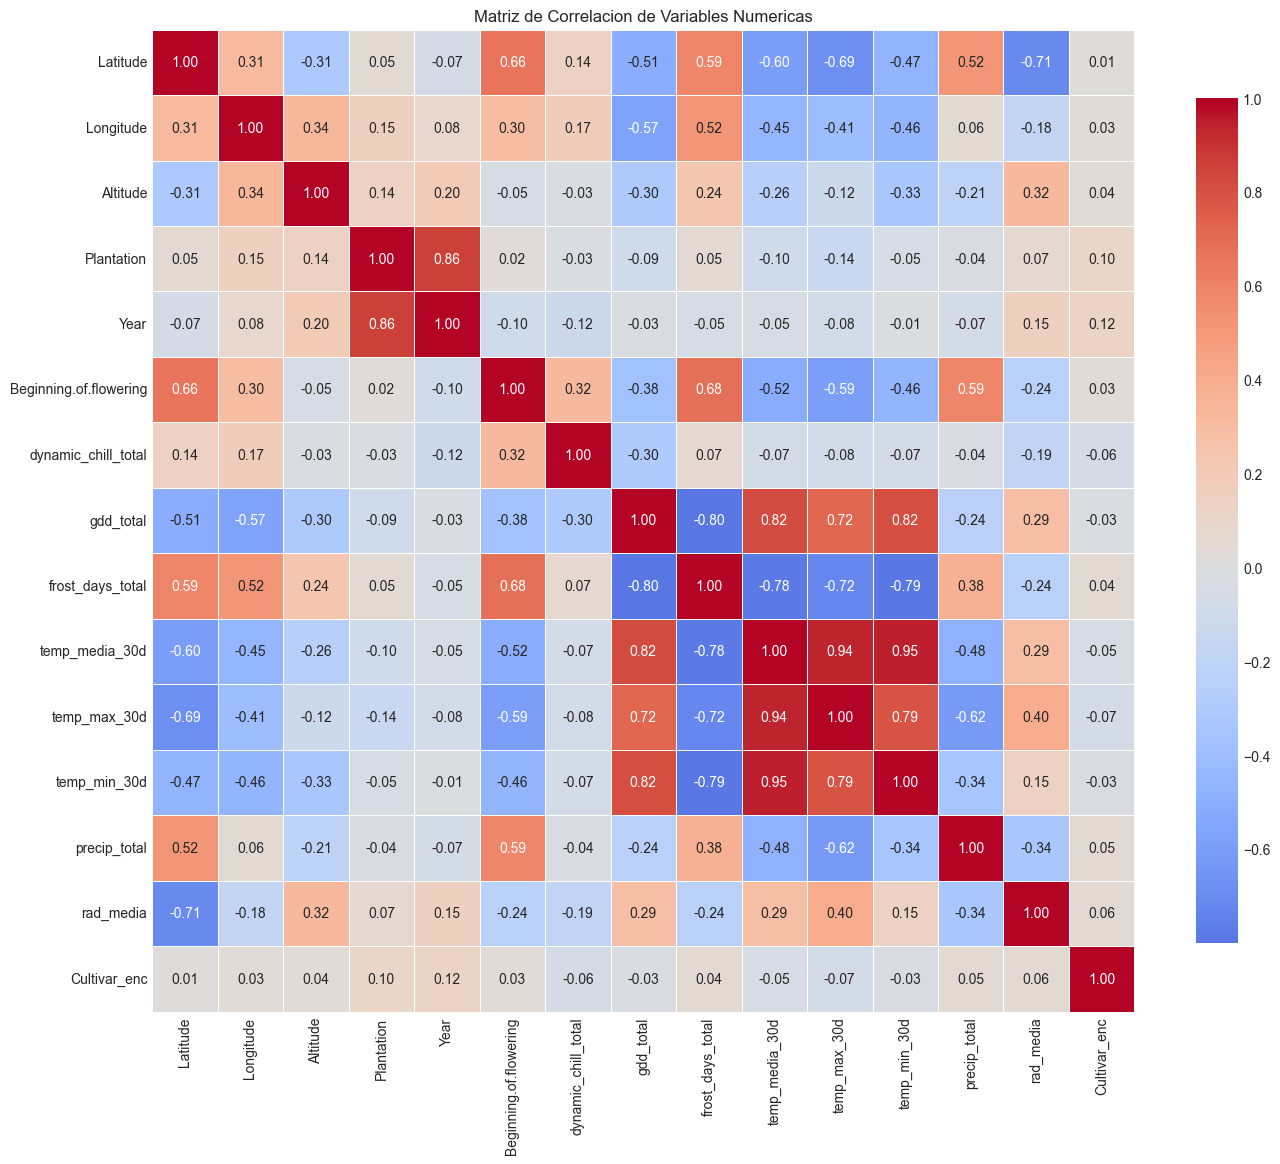


Correlaciones mas fuertes con Beginning.of.flowering:
Beginning.of.flowering    1.000000
frost_days_total          0.678877
Latitude                  0.662792
precip_total              0.586593
dynamic_chill_total       0.321564
Longitude                 0.301624
Cultivar_enc              0.031896
Plantation                0.022939
Altitude                 -0.047691
Year                     -0.096815
Name: Beginning.of.flowering, dtype: float64


In [210]:
print("Matriz de correlacion:")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Beginning.of.flowering' in numeric_cols:
    corr_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Matriz de Correlacion de Variables Numericas')
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelaciones mas fuertes con Beginning.of.flowering:")
    target_corr = corr_matrix['Beginning.of.flowering'].sort_values(ascending=False)
    print(target_corr.head(10))

Evolucion temporal de la floracion:


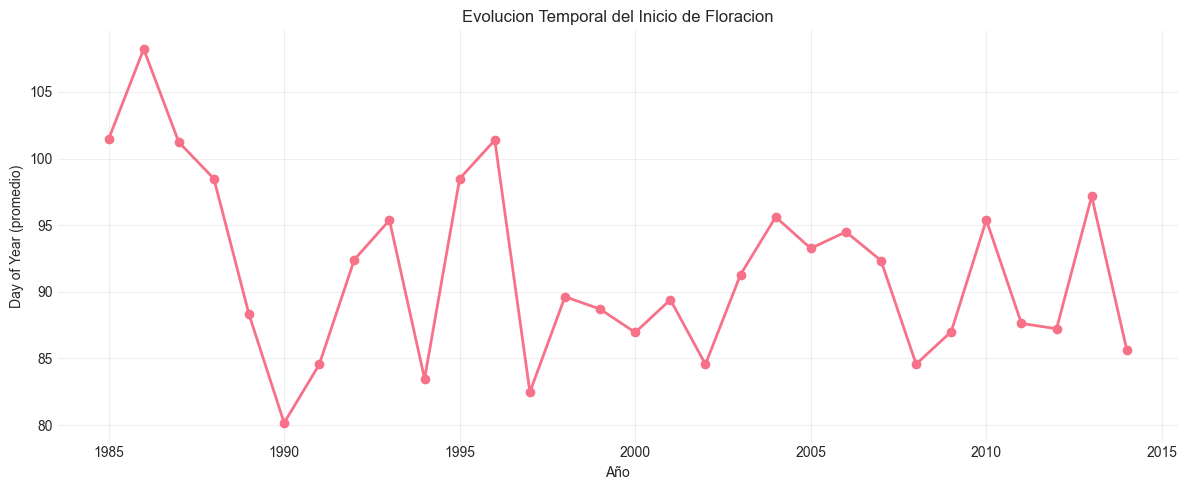

In [211]:
print("Evolucion temporal de la floracion:")

if 'Year' in df.columns and 'Beginning.of.flowering' in df.columns:
    yearly_avg = df.groupby('Year')['Beginning.of.flowering'].mean().reset_index()
    
    plt.figure(figsize=(12, 5))
    plt.plot(yearly_avg['Year'], yearly_avg['Beginning.of.flowering'], marker='o', linewidth=2)
    plt.xlabel('Año')
    plt.ylabel('Day of Year (promedio)')
    plt.title('Evolucion Temporal del Inicio de Floracion')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Floracion por cultivar (Top 15):


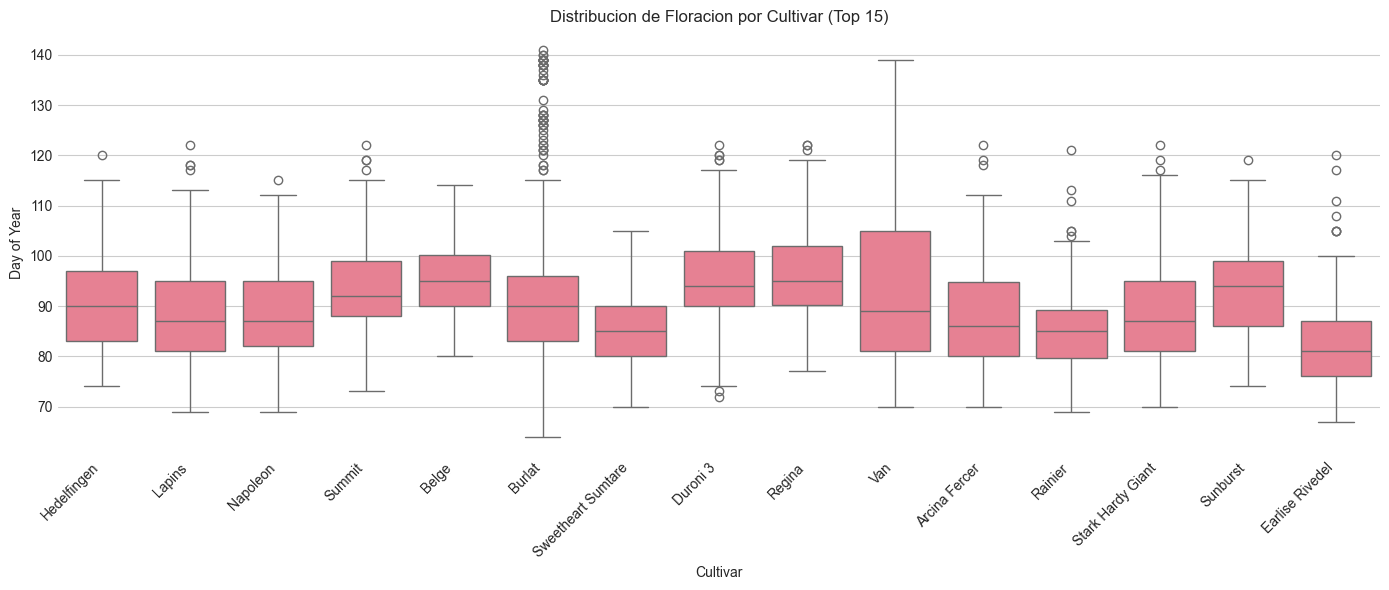

In [212]:
print("Floracion por cultivar (Top 15):")

if 'Cultivar' in df.columns and 'Beginning.of.flowering' in df.columns:
    top_cultivars = df['Cultivar'].value_counts().head(15).index
    df_plot = df[df['Cultivar'].isin(top_cultivars)]
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_plot, x='Cultivar', y='Beginning.of.flowering', hue=None)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Cultivar')
    plt.ylabel('Day of Year')
    plt.title('Distribucion de Floracion por Cultivar (Top 15)')
    plt.tight_layout()
    plt.show()

## 5. Transformacion y Preparacion de Datos

### 5a. Feature Engineering

In [213]:
print("Creacion de nuevas variables:")

# tree_age
if 'Year' in df.columns and 'Plantation' in df.columns:
    df['tree_age'] = df['Year'] - df['Plantation']
    print("- tree_age: Year - Plantation")

# temp_range
if 'temp_max_30d' in df.columns and 'temp_min_30d' in df.columns:
    df['temp_range'] = df['temp_max_30d'] - df['temp_min_30d']
    print("- temp_range: temp_max_30d - temp_min_30d")

# chill_gdd_ratio
if 'dynamic_chill_total' in df.columns and 'gdd_total' in df.columns:
    df['chill_gdd_ratio'] = df['dynamic_chill_total'] / (df['gdd_total'] + 1)
    print("- chill_gdd_ratio: dynamic_chill_total / (gdd_total + 1)")

# lat_alt_interaction
if 'Latitude' in df.columns and 'Altitude' in df.columns:
    df['lat_alt_interaction'] = df['Latitude'] * df['Altitude']
    print("- lat_alt_interaction: Latitude * Altitude")

print(f"\nNuevas features creadas: tree_age, temp_range, chill_gdd_ratio, lat_alt_interaction")
print(f"Dimensiones actuales: {df.shape}")

Creacion de nuevas variables:
- tree_age: Year - Plantation
- temp_range: temp_max_30d - temp_min_30d
- chill_gdd_ratio: dynamic_chill_total / (gdd_total + 1)
- lat_alt_interaction: Latitude * Altitude

Nuevas features creadas: tree_age, temp_range, chill_gdd_ratio, lat_alt_interaction
Dimensiones actuales: (10961, 22)


### 5b. Codificacion de Variables Categoricas

In [214]:
print("Codificacion de variables categoricas:\n")

# Country: LabelEncoder (no produce leakage, asigna enteros por orden alfabetico)
if 'Country' in df.columns:
    le_country = LabelEncoder()
    df['Country_encoded'] = le_country.fit_transform(df['Country'])
    print(f"- Country: LabelEncoder ({df['Country'].nunique()} categorias)")

# Cultivar: frequency encoding (no produce leakage, solo cuenta frecuencias)
if 'Cultivar' in df.columns:
    cultivar_freq = df['Cultivar'].value_counts().to_dict()
    df['Cultivar_freq'] = df['Cultivar'].map(cultivar_freq)
    print(f"- Cultivar: frequency encoding ({df['Cultivar'].nunique()} categorias)")

print("\nNota: Target encoding (Cultivar, Site, Institute) se calculara DESPUES del")
print("train/test split para evitar data leakage (fuga de informacion del test al train).")
print(f"\nDimensiones actuales: {df.shape}")

Codificacion de variables categoricas:

- Cultivar: frequency encoding (194 categorias)

Nota: Target encoding (Cultivar, Site, Institute) se calculara DESPUES del
train/test split para evitar data leakage (fuga de informacion del test al train).

Dimensiones actuales: (10961, 23)


### 5c. Seleccion de Features

In [215]:
print("Eliminando variables categoricas que ya no se necesitan:")

# Country ya codificado con LabelEncoder, Clone tiene baja predictibilidad
# Cultivar, Site, Institute se MANTIENEN para target encoding post-split
cols_to_drop_cat = ['Country', 'Clone','Plantation','Year']
cols_to_drop_cat = [col for col in cols_to_drop_cat if col in df.columns]

df = df.drop(columns=cols_to_drop_cat)
print(f"Columnas eliminadas: {cols_to_drop_cat}")
print("Columnas mantenidas para target encoding post-split: Cultivar, Site, Institute")

print(f"\nVerificacion de valores nulos: {df.isnull().sum().sum()}")
print(f"Dimensiones actuales: {df.shape}")

print("\nColumnas actuales:")
print(df.columns.tolist())

Eliminando variables categoricas que ya no se necesitan:
Columnas eliminadas: ['Clone', 'Plantation', 'Year']
Columnas mantenidas para target encoding post-split: Cultivar, Site, Institute

Verificacion de valores nulos: 0
Dimensiones actuales: (10961, 20)

Columnas actuales:
['Site', 'Latitude', 'Longitude', 'Altitude', 'Cultivar', 'Beginning.of.flowering', 'dynamic_chill_total', 'gdd_total', 'frost_days_total', 'temp_media_30d', 'temp_max_30d', 'temp_min_30d', 'precip_total', 'rad_media', 'Cultivar_enc', 'tree_age', 'temp_range', 'chill_gdd_ratio', 'lat_alt_interaction', 'Cultivar_freq']


### 5d. Separacion X/y

In [216]:
print("Separacion de features (X) y target (y):")

if 'Beginning.of.flowering' in df.columns:
    y = df['Beginning.of.flowering']
    X = df.drop(columns=['Beginning.of.flowering'])
    
    numeric_feats = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = X.select_dtypes(exclude=[np.number]).columns.tolist()
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"\nFeatures numericas ({len(numeric_feats)}): {numeric_feats}")
    print(f"Features categoricas pendientes de target encoding ({len(cat_feats)}): {cat_feats}")
else:
    print("ERROR: Target variable 'Beginning.of.flowering' not found")

Separacion de features (X) y target (y):
X shape: (10961, 19)
y shape: (10961,)

Features numericas (17): ['Latitude', 'Longitude', 'Altitude', 'dynamic_chill_total', 'gdd_total', 'frost_days_total', 'temp_media_30d', 'temp_max_30d', 'temp_min_30d', 'precip_total', 'rad_media', 'Cultivar_enc', 'tree_age', 'temp_range', 'chill_gdd_ratio', 'lat_alt_interaction', 'Cultivar_freq']
Features categoricas pendientes de target encoding (2): ['Site', 'Cultivar']


### 5e. Division Train/Test 80/20

Division del dataset en train (80%) y test (20%):

Train set: 8768 muestras
Test set: 2193 muestras

--- Target Encoding (calculado SOLO en train) ---
Esto evita que informacion del test 'fugue' al entrenamiento.

  Cultivar_target: 194 grupos en train | 0 categorias no vistas en test
  Site_target: 21 grupos en train | 0 categorias no vistas en test

Train final: (8768, 19)
Test final: (2193, 19)

Features (19): ['Latitude', 'Longitude', 'Altitude', 'dynamic_chill_total', 'gdd_total', 'frost_days_total', 'temp_media_30d', 'temp_max_30d', 'temp_min_30d', 'precip_total', 'rad_media', 'Cultivar_enc', 'tree_age', 'temp_range', 'chill_gdd_ratio', 'lat_alt_interaction', 'Cultivar_freq', 'Cultivar_target', 'Site_target']


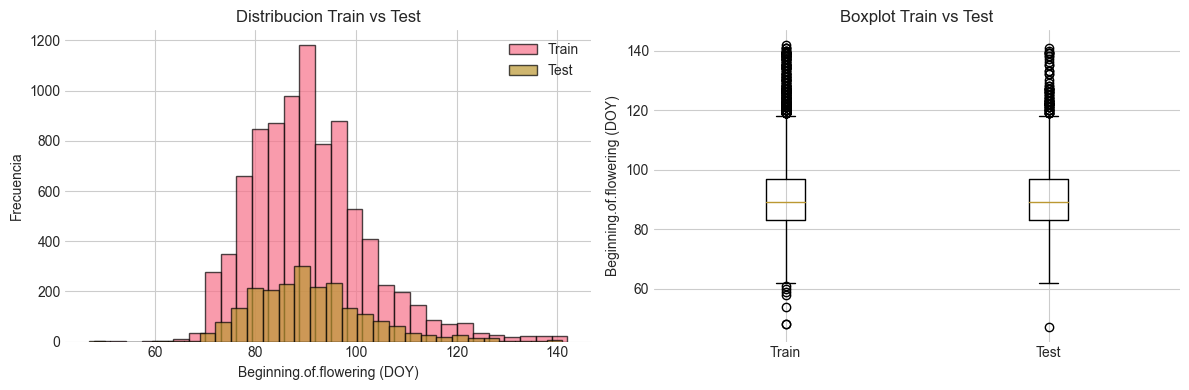


Estadisticas Train: Media=90.74, Std=11.74
Estadisticas Test: Media=91.13, Std=11.80


In [217]:
print("Division del dataset en train (80%) y test (20%):\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")

# --- Target Encoding calculado SOLO en train (evita data leakage) ---
print("\n--- Target Encoding (calculado SOLO en train) ---")
print("Esto evita que informacion del test 'fugue' al entrenamiento.\n")

global_mean = y_train.mean()

for col in ['Cultivar', 'Site']:
    if col in X_train.columns:
        # Calcular media del target por grupo SOLO con datos de train
        target_means = y_train.groupby(X_train[col]).mean()
        
        # Aplicar a train
        X_train[f'{col}_target'] = X_train[col].map(target_means)
        
        # Aplicar a test (categorias no vistas en train -> media global)
        X_test[f'{col}_target'] = X_test[col].map(target_means)
        n_unseen = X_test[f'{col}_target'].isnull().sum()
        X_test[f'{col}_target'] = X_test[f'{col}_target'].fillna(global_mean)
        
        print(f"  {col}_target: {len(target_means)} grupos en train | {n_unseen} categorias no vistas en test")

# Eliminar columnas categoricas originales de train y test
cat_cols = ['Cultivar', 'Site', 'Institute','Plantation','Year']
cat_cols = [c for c in cat_cols if c in X_train.columns]
X_train = X_train.drop(columns=cat_cols)
X_test = X_test.drop(columns=cat_cols)

print(f"\nTrain final: {X_train.shape}")
print(f"Test final: {X_test.shape}")
print(f"\nFeatures ({X_train.shape[1]}): {X_train.columns.tolist()}")

# Comparacion de distribuciones
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, alpha=0.7, label='Train', edgecolor='black')
plt.hist(y_test, bins=30, alpha=0.7, label='Test', edgecolor='black')
plt.xlabel('Beginning.of.flowering (DOY)')
plt.ylabel('Frecuencia')
plt.title('Distribucion Train vs Test')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([y_train, y_test], labels=['Train', 'Test'])
plt.ylabel('Beginning.of.flowering (DOY)')
plt.title('Boxplot Train vs Test')

plt.tight_layout()
plt.show()

print(f"\nEstadisticas Train: Media={y_train.mean():.2f}, Std={y_train.std():.2f}")
print(f"Estadisticas Test: Media={y_test.mean():.2f}, Std={y_test.std():.2f}")

### 5f. Escalado de Features

In [218]:
print("Comparacion de escaladores: StandardScaler vs RobustScaler")
print("Decision: RobustScaler para modelos lineales (mas robusto a outliers residuales)\n")

# StandardScaler
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

# RobustScaler
scaler_robust = RobustScaler()
X_train_scaled = scaler_robust.fit_transform(X_train)
X_test_scaled = scaler_robust.transform(X_test)

print("Escaladores ajustados:")
print("- StandardScaler: media=0, std=1")
print("- RobustScaler: mediana=0, IQR=1")
print("\nRobustScaler sera usado para modelos lineales (Linear, Ridge, Lasso)")
print("Modelos basados en arboles usaran datos sin escalar")

Comparacion de escaladores: StandardScaler vs RobustScaler
Decision: RobustScaler para modelos lineales (mas robusto a outliers residuales)

Escaladores ajustados:
- StandardScaler: media=0, std=1
- RobustScaler: mediana=0, IQR=1

RobustScaler sera usado para modelos lineales (Linear, Ridge, Lasso)
Modelos basados en arboles usaran datos sin escalar


## 6. Modelado

In [219]:
print("Definicion de funcion de evaluacion:")

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, cv_folds= 10):
    """
    Evalua un modelo de regresion con multiples metricas.
    
    Returns:
        dict con name, model, mae, rmse, r2, mae_train, r2_train, cv_mae, y_pred
    """
    # Entrenar
    model.fit(X_tr, y_tr)
    
    # Predicciones en test
    y_pred = model.predict(X_te)
    
    # Predicciones en train (para detectar overfitting)
    y_pred_train = model.predict(X_tr)
    
    # Metricas en test
    mae = MAE(y_te, y_pred)
    rmse = np.sqrt(MSE(y_te, y_pred))
    r2 = R2(y_te, y_pred)
    
    # Metricas en train
    mae_train = MAE(y_tr, y_pred_train)
    r2_train = R2(y_tr, y_pred_train)
    
    # Cross-validation en train
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=kfold, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()
    
    return {
        'name': name,
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mae_train': mae_train,
        'r2_train': r2_train,
        'cv_mae': cv_mae,
        'y_pred': y_pred
    }

print("Funcion evaluate_model definida (con metricas train + test).")

Definicion de funcion de evaluacion:
Funcion evaluate_model definida (con metricas train + test).


## 7. Evaluacion de Modelos

ENTRENAMIENTO DE MODELOS

1️⃣  Modelos Lineales (con RobustScaler):
   ✅ Linear Regression
   ✅ Ridge (L2)
   ✅ Lasso (L1)

2️⃣  Modelos Basados en Árboles (sin escalar):
   ✅ Random Forest
   ✅ Gradient Boosting
   ✅ XGBoost
   ✅ LightGBM

✅ Total modelos entrenados: 7

COMPARACIÓN DE MODELOS

📊 Métricas de Performance:
            Model  MAE_Train  MAE_Test  RMSE    R2  CV_MAE
Gradient Boosting      0.642     0.794 1.164 0.990   0.809
          XGBoost      0.668     0.804 1.175 0.990   0.832
         LightGBM      0.695     0.836 1.242 0.989   0.861
    Random Forest      1.415     1.600 2.295 0.962   1.635
            Ridge      2.447     2.423 3.140 0.929   2.453
Linear Regression      2.447     2.431 3.143 0.929   2.453
            Lasso      2.661     2.598 3.341 0.920   2.666


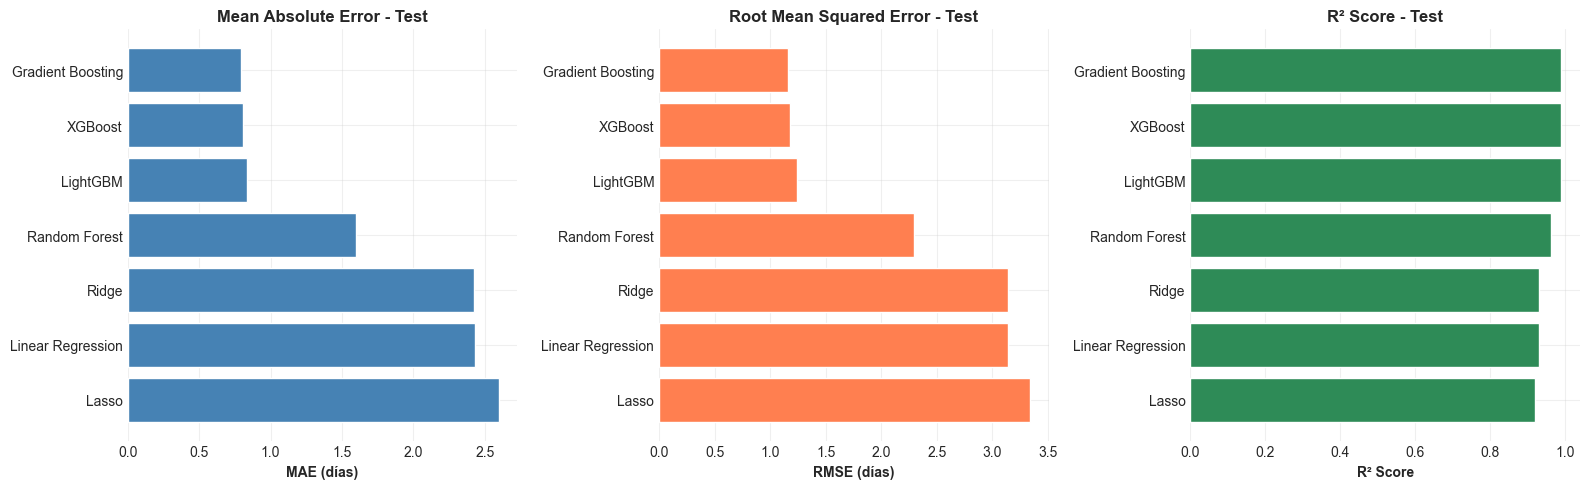


🏆 Mejor modelo (por MAE): Gradient Boosting
   MAE: 0.794 días
   R²:  0.99

ANÁLISIS DE OVERFITTING

📋 Diagnóstico de Overfitting:
            Model  MAE_Train  MAE_Test  MAE_Ratio  R2_Train  R2_Test   R2_Diff            Diagnóstico
Linear Regression   2.446678  2.430965   0.993578  0.927148 0.928978 -0.001830      ✅ Sin Overfitting
            Ridge   2.447208  2.423092   0.990146  0.926794 0.929143 -0.002349      ✅ Sin Overfitting
            Lasso   2.660625  2.598024   0.976471  0.915116 0.919760 -0.004644      ✅ Sin Overfitting
    Random Forest   1.415361  1.600090   1.130517  0.969867 0.962142  0.007725      ✅ Sin Overfitting
Gradient Boosting   0.641821  0.794358   1.237663  0.994056 0.990254  0.003802 ⚡ Overfitting Moderado
          XGBoost   0.667549  0.804476   1.205119  0.993384 0.990070  0.003313 ⚡ Overfitting Moderado
         LightGBM   0.695019  0.836500   1.203564  0.992663 0.988918  0.003745 ⚡ Overfitting Moderado


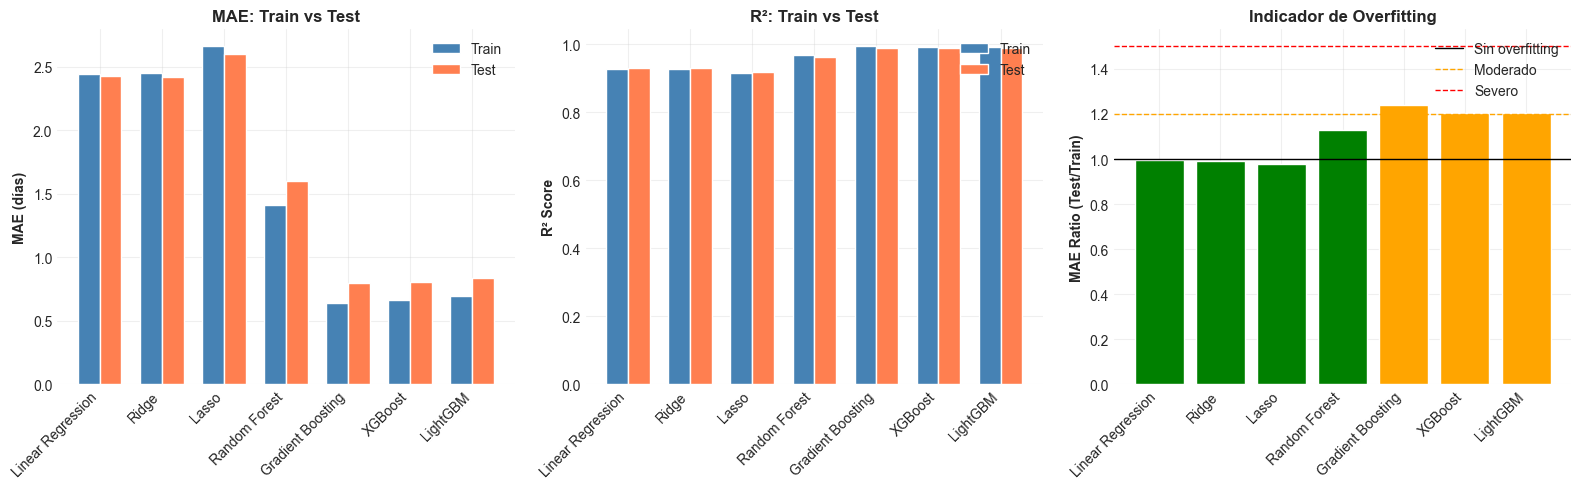


📊 Interpretación:
   - MAE Ratio ≈ 1.0: Generalización perfecta
   - MAE Ratio 1.0-1.2: Excelente (sin overfitting)
   - MAE Ratio 1.2-1.5: Moderado (aceptable)
   - MAE Ratio > 1.5: Severo (revisar hiperparámetros)



In [220]:
print("="*80)
print("ENTRENAMIENTO DE MODELOS")
print("="*80)

results = []

# ============================================================================
# 1. MODELOS LINEALES (con datos escalados)
# ============================================================================
print("\n1️⃣  Modelos Lineales (con RobustScaler):")

results.append(evaluate_model(
    'Linear Regression', 
    LinearRegression(), 
    X_train_scaled, y_train, X_test_scaled, y_test
))
print("   ✅ Linear Regression")

results.append(evaluate_model(
    'Ridge', 
    Ridge(alpha=1.0, random_state=42), 
    X_train_scaled, y_train, X_test_scaled, y_test
))
print("   ✅ Ridge (L2)")

results.append(evaluate_model(
    'Lasso', 
    Lasso(alpha=0.1, random_state=42), 
    X_train_scaled, y_train, X_test_scaled, y_test
))
print("   ✅ Lasso (L1)")

# ============================================================================
# 2. MODELOS BASADOS EN ÁRBOLES (sin escalar)
# ============================================================================
print("\n2️⃣  Modelos Basados en Árboles (sin escalar):")

# ─────────────────────────────────────────────────────────────────────────────
# Random Forest
# ─────────────────────────────────────────────────────────────────────────────
results.append(evaluate_model(
    'Random Forest', 
    RandomForestRegressor(
        n_estimators=200,          # Balance velocidad/performance
        max_depth=10,              # Limita profundidad
        min_samples_split=10,      # Mínimo para hacer split
        min_samples_leaf=4,        # Evita hojas pequeñas
        max_features='sqrt',       # Feature sampling
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    ), 
    X_train, y_train, X_test, y_test
))
print("   ✅ Random Forest")

# ─────────────────────────────────────────────────────────────────────────────
# Gradient Boosting
# ─────────────────────────────────────────────────────────────────────────────
results.append(evaluate_model(
    'Gradient Boosting', 
    GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,        # Conservador
        max_depth=4,               # Evita overfitting
        min_samples_split=10,
        min_samples_leaf=4,
        subsample=0.8,             # Stochastic boosting
        random_state=42
    ), 
    X_train, y_train, X_test, y_test
))
print("   ✅ Gradient Boosting")

# ─────────────────────────────────────────────────────────────────────────────
# XGBoost
# ─────────────────────────────────────────────────────────────────────────────
results.append(evaluate_model(
    'XGBoost', 
    XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=4,        # Similar a min_samples_leaf
        subsample=0.8,
        colsample_bytree=0.8,      # Feature sampling
        reg_alpha=0.1,             # L1 regularización
        reg_lambda=1.0,            # L2 regularización
        random_state=42,
        verbosity=0
    ), 
    X_train, y_train, X_test, y_test
))
print("   ✅ XGBoost")

# ─────────────────────────────────────────────────────────────────────────────
# LightGBM
# ─────────────────────────────────────────────────────────────────────────────
results.append(evaluate_model(
    'LightGBM', 
    LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        num_leaves=15,             # 2^max_depth - 1
        min_child_samples=10,      # Similar a min_samples_leaf
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1
    ), 
    X_train, y_train, X_test, y_test
))
print("   ✅ LightGBM")

print(f"\n✅ Total modelos entrenados: {len(results)}")

# ============================================================================
# 3. COMPARACIÓN DE MODELOS
# ============================================================================
print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)

comparison_df = pd.DataFrame([{
    'Model': r['name'],
    'MAE_Train': round(r['mae_train'], 3),
    'MAE_Test': round(r['mae'], 3),
    'RMSE': round(r['rmse'], 3),
    'R2': round(r['r2'], 3),
    'CV_MAE': round(r['cv_mae'], 3)
} for r in results])

comparison_df = comparison_df.sort_values('MAE_Test')
print("\n📊 Métricas de Performance:")
print(comparison_df.to_string(index=False))

# Gráficos comparativos
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# MAE
axes[0].barh(comparison_df['Model'], comparison_df['MAE_Test'], color='steelblue')
axes[0].set_xlabel('MAE (días)', fontweight='bold')
axes[0].set_title('Mean Absolute Error - Test', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3)

# RMSE
axes[1].barh(comparison_df['Model'], comparison_df['RMSE'], color='coral')
axes[1].set_xlabel('RMSE (días)', fontweight='bold')
axes[1].set_title('Root Mean Squared Error - Test', fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3)

# R2
axes[2].barh(comparison_df['Model'], comparison_df['R2'], color='seagreen')
axes[2].set_xlabel('R² Score', fontweight='bold')
axes[2].set_title('R² Score - Test', fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🏆 Mejor modelo (por MAE): {comparison_df.iloc[0]['Model']}")
print(f"   MAE: {comparison_df.iloc[0]['MAE_Test']} días")
print(f"   R²:  {comparison_df.iloc[0]['R2']}")

# ============================================================================
# 4. ANÁLISIS DE OVERFITTING
# ============================================================================
print("\n" + "="*80)
print("ANÁLISIS DE OVERFITTING")
print("="*80)

overfit_df = pd.DataFrame([{
    'Model': r['name'],
    'MAE_Train': r['mae_train'],
    'MAE_Test': r['mae'],
    'CV_MAE': r['cv_mae'],
    'R2_Train': r['r2_train'],
    'R2_Test': r['r2']
} for r in results])

# Indicadores de overfitting (CORREGIDO)
overfit_df['MAE_Diff'] = overfit_df['MAE_Test'] - overfit_df['MAE_Train']
overfit_df['MAE_Ratio'] = overfit_df['MAE_Test'] / (overfit_df['MAE_Train'] + 1e-8)  # ← CORREGIDO
overfit_df['R2_Diff'] = overfit_df['R2_Train'] - overfit_df['R2_Test']

# Clasificación
def classify_overfitting(row):
    if row['MAE_Ratio'] > 1.5 or row['R2_Diff'] > 0.15:
        return "⚠️  Overfitting Significativo"
    elif row['MAE_Ratio'] > 1.2 or row['R2_Diff'] > 0.08:
        return "⚡ Overfitting Moderado"
    else:
        return "✅ Sin Overfitting"

overfit_df['Diagnóstico'] = overfit_df.apply(classify_overfitting, axis=1)

print("\n📋 Diagnóstico de Overfitting:")
print(overfit_df[['Model', 'MAE_Train', 'MAE_Test', 'MAE_Ratio', 
                  'R2_Train', 'R2_Test', 'R2_Diff', 'Diagnóstico']].to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
x_pos = range(len(overfit_df))
width = 0.35

# MAE Train vs Test
axes[0].bar([p - width/2 for p in x_pos], overfit_df['MAE_Train'], 
           width, label='Train', color='steelblue')
axes[0].bar([p + width/2 for p in x_pos], overfit_df['MAE_Test'], 
           width, label='Test', color='coral')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(overfit_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('MAE (días)', fontweight='bold')
axes[0].set_title('MAE: Train vs Test', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# R2 Train vs Test
axes[1].bar([p - width/2 for p in x_pos], overfit_df['R2_Train'], 
           width, label='Train', color='steelblue')
axes[1].bar([p + width/2 for p in x_pos], overfit_df['R2_Test'], 
           width, label='Test', color='coral')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(overfit_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('R²: Train vs Test', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# MAE Ratio (indicador de overfitting)
colors = ['green' if r < 1.2 else 'orange' if r < 1.5 else 'red' 
          for r in overfit_df['MAE_Ratio']]
axes[2].bar(x_pos, overfit_df['MAE_Ratio'], color=colors)
axes[2].axhline(1.0, color='black', linestyle='-', linewidth=1, label='Sin overfitting')
axes[2].axhline(1.2, color='orange', linestyle='--', linewidth=1, label='Moderado')
axes[2].axhline(1.5, color='red', linestyle='--', linewidth=1, label='Severo')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(overfit_df['Model'], rotation=45, ha='right')
axes[2].set_ylabel('MAE Ratio (Test/Train)', fontweight='bold')
axes[2].set_title('Indicador de Overfitting', fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretación
print("\n📊 Interpretación:")
print("   - MAE Ratio ≈ 1.0: Generalización perfecta")
print("   - MAE Ratio 1.0-1.2: Excelente (sin overfitting)")
print("   - MAE Ratio 1.2-1.5: Moderado (aceptable)")
print("   - MAE Ratio > 1.5: Severo (revisar hiperparámetros)")

print("\n" + "="*80)

### 7a. Análisis del Mejor Modelo

Analisis del mejor modelo:

Modelo: Random Forest
MAE: 1.600 dias
RMSE: 2.295 dias
R2: 0.962


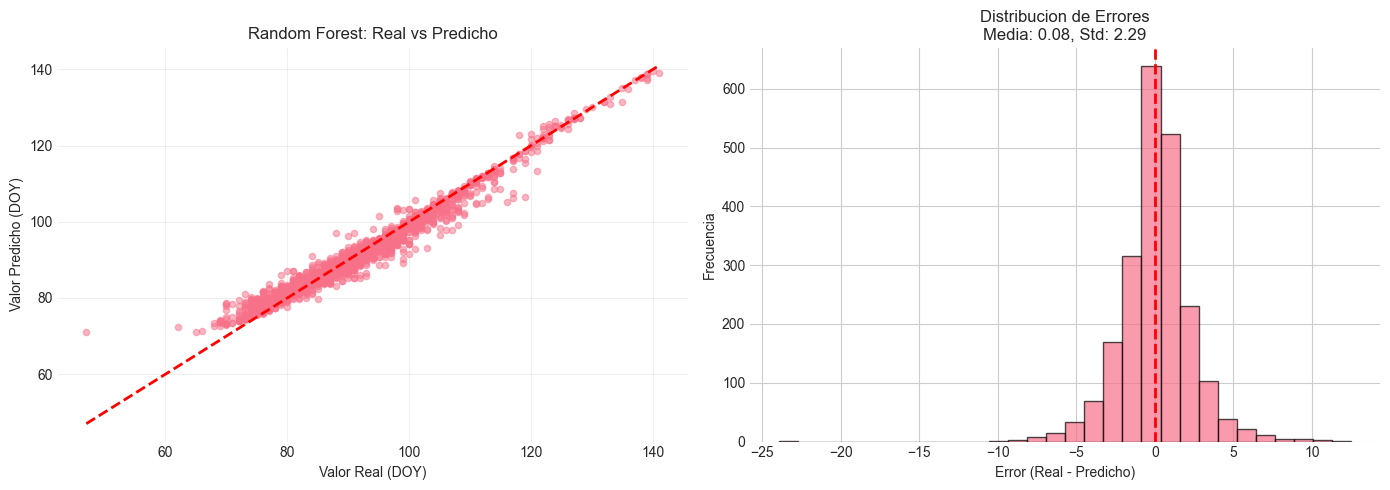

In [221]:
print("Analisis del mejor modelo:\n")
# Supongamos que quieres usar LightGBM
selected_name = 'Random Forest'

best_result = next(r for r in results if r['name'] == selected_name)
best_name = best_result['name']
best_pred = best_result['y_pred']

#print(f"Modelo seleccionado: {best_name}")
# Obtener mejor modelo
# best_result = min(results, key=lambda x: x['mae'])
# best_name = best_result['name']
# best_pred = best_result['y_pred']

print(f"Modelo: {best_name}")
print(f"MAE: {best_result['mae']:.3f} dias")
print(f"RMSE: {best_result['rmse']:.3f} dias")
print(f"R2: {best_result['r2']:.3f}")

# Grafico real vs predicho
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter real vs predicho
axes[0].scatter(y_test, best_pred, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Valor Real (DOY)')
axes[0].set_ylabel('Valor Predicho (DOY)')
axes[0].set_title(f'{best_name}: Real vs Predicho')
axes[0].grid(True, alpha=0.3)

# Distribucion de errores
errors = y_test - best_pred
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Error (Real - Predicho)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribucion de Errores\nMedia: {errors.mean():.2f}, Std: {errors.std():.2f}')

plt.tight_layout()
plt.show()

Top 15 features más importantes Random Forest:
            Feature  Importance
dynamic_chill_total    0.153815
   frost_days_total    0.145559
           Latitude    0.131354
        Site_target    0.107099
       precip_total    0.097540
       temp_max_30d    0.047066
          Longitude    0.046758
          rad_media    0.045027
          gdd_total    0.040189
    chill_gdd_ratio    0.036097
    Cultivar_target    0.030945
     temp_media_30d    0.027398
       temp_min_30d    0.024392
           Altitude    0.022167
         temp_range    0.020850


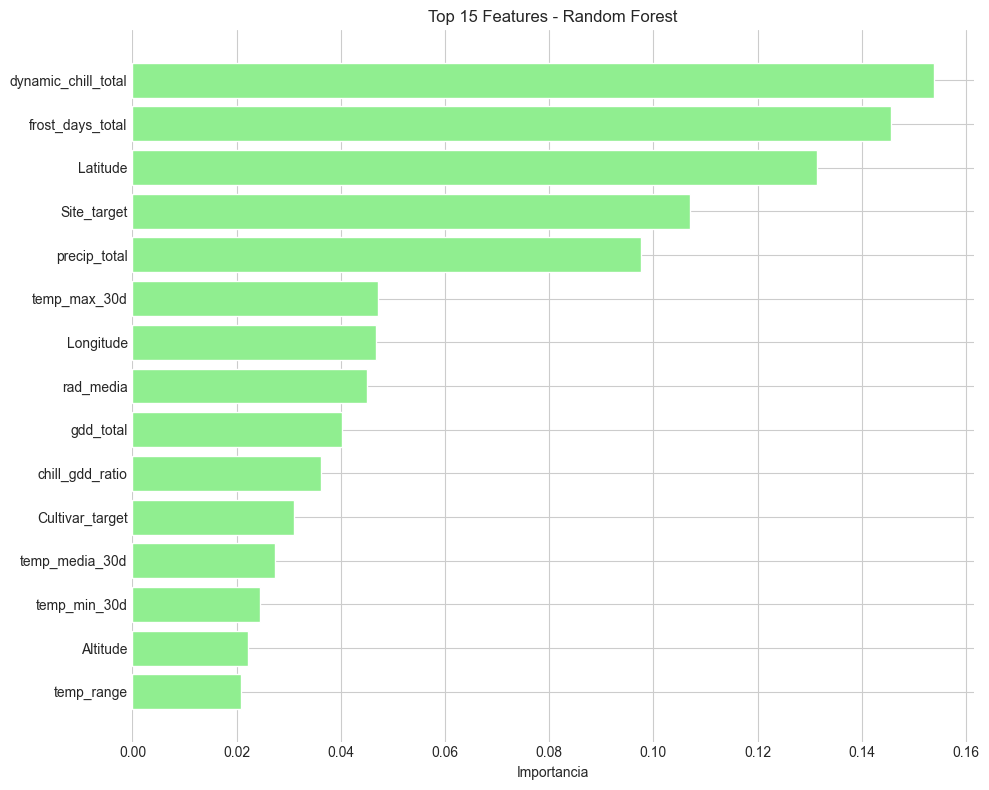

In [223]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar Gradient Boosting
# gb_result = next(r for r in results if r['name'] == 'Gradient Boosting')
gb_result = next(r for r in results if r['name'] == best_name)
gb_model = gb_result['model']

# Obtener importancia de features
importances = gb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Mostrar Top 15
print(f"Top 15 features más importantes {best_name}:")
print(feature_importance_df.head(15).to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='lightgreen')
plt.xlabel('Importancia')
plt.title(f'Top 15 Features - {best_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Analisis de errores por rango de floracion:

          Segmento   N      MAE      Std       Max
   Temprana (<=83) 599 2.031022 1.849736 23.956007
Media-temp (83-89) 499 1.071545 1.007433  8.963474
Media-tard (89-97) 554 1.465753 1.330781  7.468335
      Tardia (>97) 541 1.748034 1.987440 12.528087


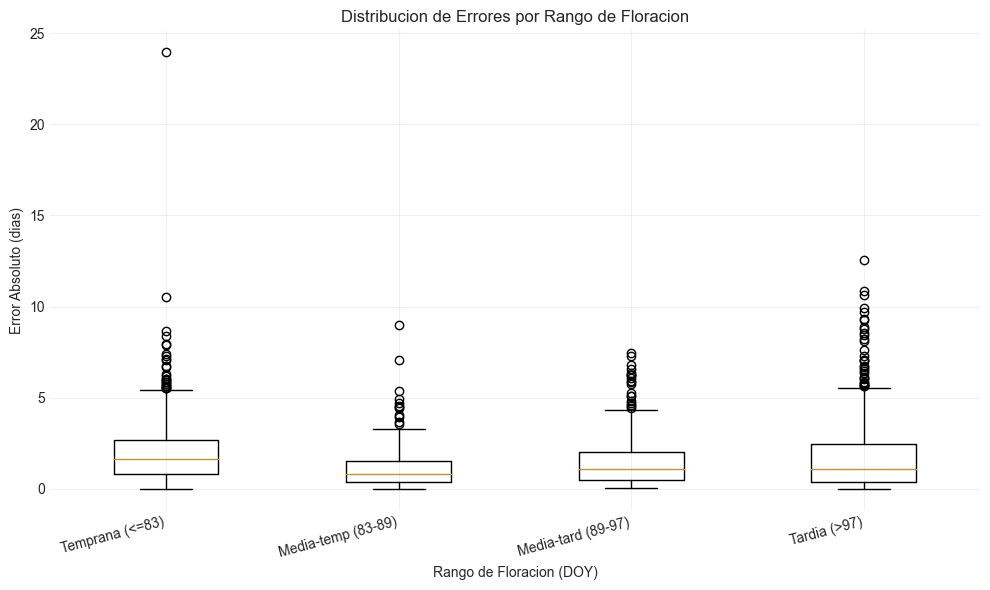

In [224]:
print("Analisis de errores por rango de floracion:\n")

# Crear segmentos
#best_result = min(results, key=lambda x: x['mae'])
best_pred = best_result['y_pred']
errors = np.abs(y_test - best_pred)

# Definir rangos (cuartiles)
q1 = y_test.quantile(0.25)
q2 = y_test.quantile(0.50)
q3 = y_test.quantile(0.75)

segments = []
segment_names = []

# Temprana
mask_early = y_test <= q1
segments.append(errors[mask_early])
segment_names.append(f'Temprana (<={q1:.0f})')

# Media-temprana
mask_mid_early = (y_test > q1) & (y_test <= q2)
segments.append(errors[mask_mid_early])
segment_names.append(f'Media-temp ({q1:.0f}-{q2:.0f})')

# Media-tardia
mask_mid_late = (y_test > q2) & (y_test <= q3)
segments.append(errors[mask_mid_late])
segment_names.append(f'Media-tard ({q2:.0f}-{q3:.0f})')

# Tardia
mask_late = y_test > q3
segments.append(errors[mask_late])
segment_names.append(f'Tardia (>{q3:.0f})')

# Estadisticas por segmento
error_analysis = pd.DataFrame([{
    'Segmento': segment_names[i],
    'N': len(segments[i]),
    'MAE': segments[i].mean(),
    'Std': segments[i].std(),
    'Max': segments[i].max()
} for i in range(len(segments))])

print(error_analysis.to_string(index=False))

# Boxplot por segmento
plt.figure(figsize=(10, 6))
plt.boxplot(segments, labels=segment_names)
plt.ylabel('Error Absoluto (dias)')
plt.xlabel('Rango de Floracion (DOY)')
plt.title('Distribucion de Errores por Rango de Floracion')
plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Análisis de residuos

In [ ]:
"""
===============================================================================
ANÁLISIS EXHAUSTIVO DE RESIDUOS - MODELO DE FLORACIÓN DE CEREZOS
===============================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression as LR_aux
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score as R2
import os

# Crear carpeta results si no existe
os.makedirs('./results', exist_ok=True)

# ============================================================================
# CONFIGURACIÓN DE ESTILO
# ============================================================================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'danger': '#C73E1D',
    'neutral': '#6C757D'
}

# ============================================================================
# FUNCIÓN PRINCIPAL DE ANÁLISIS DE RESIDUOS
# ============================================================================

def analizar_residuos_completo(model, X_train, y_train, X_test, y_test, 
                                feature_names=None, modelo_nombre="Modelo"):
    """
    Análisis completo de residuos para un modelo de regresión.
    
    Parameters:
    -----------
    model : sklearn model
        Modelo entrenado
    X_train : array-like
        Features de entrenamiento
    y_train : array-like
        Target de entrenamiento
    X_test : array-like
        Features de test
    y_test : array-like
        Target de test
    feature_names : list, optional
        Nombres de las features
    modelo_nombre : str, optional
        Nombre del modelo para los gráficos
        
    Returns:
    --------
    dict : Diccionario con métricas y resultados del análisis
    """
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Residuos
    residuos_train = y_train - y_train_pred
    residuos_test = y_test - y_test_pred
    
    # Residuos estandarizados
    std_residuos_train = residuos_train / np.std(residuos_train)
    std_residuos_test = residuos_test / np.std(residuos_test)
    
    print("="*80)
    print(f"ANÁLISIS DE RESIDUOS - {modelo_nombre}")
    print("="*80)
    
    # ========================================================================
    # 1. MÉTRICAS BÁSICAS
    # ========================================================================
    print("\n📊 MÉTRICAS DE RESIDUOS")
    print("-" * 80)
    
    metrics_train = {
        'MAE': MAE(y_train, y_train_pred),
        'RMSE': np.sqrt(MSE(y_train, y_train_pred)),
        'R²': R2(y_train, y_train_pred),
        'Media Residuos': np.mean(residuos_train),
        'Std Residuos': np.std(residuos_train),
        'Min Residuo': np.min(residuos_train),
        'Max Residuo': np.max(residuos_train)
    }
    
    metrics_test = {
        'MAE': MAE(y_test, y_test_pred),
        'RMSE': np.sqrt(MSE(y_test, y_test_pred)),
        'R²': R2(y_test, y_test_pred),
        'Media Residuos': np.mean(residuos_test),
        'Std Residuos': np.std(residuos_test),
        'Min Residuo': np.min(residuos_test),
        'Max Residuo': np.max(residuos_test)
    }
    
    df_metrics = pd.DataFrame({
        'Train': metrics_train,
        'Test': metrics_test
    }).round(4)
    
    print(df_metrics)
    
    # ========================================================================
    # 2. TESTS ESTADÍSTICOS
    # ========================================================================
    print("\n\n🧪 TESTS ESTADÍSTICOS")
    print("-" * 80)
    
    # Test de normalidad
    if len(residuos_test) < 5000:
        stat_norm, p_norm = stats.shapiro(residuos_test)
        test_nombre = "Shapiro-Wilk"
    else:
        stat_norm, p_norm = stats.kstest(residuos_test, 'norm')
        test_nombre = "Kolmogorov-Smirnov"
    
    print(f"\n1. Test de Normalidad ({test_nombre}):")
    print(f"   Estadístico: {stat_norm:.4f}")
    print(f"   p-valor: {p_norm:.4f}")
    if p_norm > 0.05:
        print("   ✅ No se rechaza H0: Los residuos parecen normales (p > 0.05)")
    else:
        print("   ⚠️  Se rechaza H0: Los residuos NO son normales (p < 0.05)")
    
    # Test de homoscedasticidad: Breusch-Pagan
    residuos_abs = np.abs(residuos_test)
    lr_aux = LR_aux()
    lr_aux.fit(y_test_pred.reshape(-1, 1), residuos_abs)
    r2_aux = lr_aux.score(y_test_pred.reshape(-1, 1), residuos_abs)
    n = len(residuos_test)
    bp_stat = n * r2_aux
    bp_pval = 1 - chi2.cdf(bp_stat, 1)
    
    print(f"\n2. Test de Homoscedasticidad (Breusch-Pagan):")
    print(f"   Estadístico: {bp_stat:.4f}")
    print(f"   p-valor: {bp_pval:.4f}")
    if bp_pval > 0.05:
        print("   ✅ No se rechaza H0: Varianza constante (p > 0.05)")
    else:
        print("   ⚠️  Se rechaza H0: Heterocedasticidad detectada (p < 0.05)")
    
    # Test de Durbin-Watson
    dw = np.sum(np.diff(residuos_test)**2) / np.sum(residuos_test**2)
    print(f"\n3. Test de Durbin-Watson (autocorrelación):")
    print(f"   Estadístico DW: {dw:.4f}")
    if 1.5 < dw < 2.5:
        print("   ✅ No hay autocorrelación significativa (DW ≈ 2)")
    elif dw < 1.5:
        print("   ⚠️  Autocorrelación positiva detectada (DW < 1.5)")
    else:
        print("   ⚠️  Autocorrelación negativa detectada (DW > 2.5)")
    
    # ========================================================================
    # 3. DETECCIÓN DE OUTLIERS
    # ========================================================================
    print("\n\n🎯 DETECCIÓN DE OUTLIERS")
    print("-" * 80)
    
    outliers_std = np.abs(std_residuos_test) > 3
    n_outliers_std = np.sum(outliers_std)
    pct_outliers_std = 100 * n_outliers_std / len(residuos_test)
    
    print(f"\nMétodo 1 - Residuos Estandarizados > 3:")
    print(f"   Outliers detectados: {n_outliers_std} ({pct_outliers_std:.2f}%)")
    
    Q1_r = np.percentile(residuos_test, 25)
    Q3_r = np.percentile(residuos_test, 75)
    IQR_r = Q3_r - Q1_r
    outliers_iqr = (residuos_test < Q1_r - 1.5*IQR_r) | (residuos_test > Q3_r + 1.5*IQR_r)
    n_outliers_iqr = np.sum(outliers_iqr)
    pct_outliers_iqr = 100 * n_outliers_iqr / len(residuos_test)
    
    print(f"\nMétodo 2 - IQR (Tukey's fences):")
    print(f"   Outliers detectados: {n_outliers_iqr} ({pct_outliers_iqr:.2f}%)")
    print(f"   Q1 = {Q1_r:.2f}, Q3 = {Q3_r:.2f}, IQR = {IQR_r:.2f}")
    
    if n_outliers_std > 0:
        idx_outliers = np.where(outliers_std)[0]
        print(f"\n   Top 10 outliers (residuos estandarizados):")
        top_outliers = sorted(zip(idx_outliers, std_residuos_test[outliers_std]), 
                             key=lambda x: abs(x[1]), reverse=True)[:10]
        for idx, std_res in top_outliers:
            print(f"      Índice {idx}: Residuo estandarizado = {std_res:.2f}, "
                  f"Real = {y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]:.1f}, "
                  f"Predicho = {y_test_pred[idx]:.1f}")
    
    # ========================================================================
    # 4. VISUALIZACIONES
    # ========================================================================
    print("\n\n📈 GENERANDO VISUALIZACIONES...")
    print("-" * 80)
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # GRÁFICO 1: Residuos vs Predicciones (Train)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(y_train_pred, residuos_train, alpha=0.5, s=30, color=COLORS['primary'])
    ax1.axhline(0, color=COLORS['danger'], linestyle='--', linewidth=2, label='y=0')
    ax1.set_xlabel('Valores Predichos (DOY)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Residuos (días)', fontsize=11, fontweight='bold')
    ax1.set_title('Residuos vs Predicciones - TRAIN', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # GRÁFICO 2: Residuos vs Predicciones (Test)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(y_test_pred, residuos_test, alpha=0.6, s=30, color=COLORS['secondary'])
    ax2.axhline(0, color=COLORS['danger'], linestyle='--', linewidth=2, label='y=0')
    std_res = np.std(residuos_test)
    ax2.axhline(2*std_res, color=COLORS['accent'], linestyle=':', linewidth=1.5, 
                label=f'±2σ = ±{2*std_res:.2f}')
    ax2.axhline(-2*std_res, color=COLORS['accent'], linestyle=':', linewidth=1.5)
    ax2.set_xlabel('Valores Predichos (DOY)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Residuos (días)', fontsize=11, fontweight='bold')
    ax2.set_title('Residuos vs Predicciones - TEST', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # GRÁFICO 3: Histograma de Residuos
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(residuos_test, bins=50, density=True, alpha=0.7, 
             color=COLORS['primary'], edgecolor='black')
    mu, sigma = np.mean(residuos_test), np.std(residuos_test)
    x = np.linspace(residuos_test.min(), residuos_test.max(), 100)
    ax3.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
             label=f'N(μ={mu:.2f}, σ={sigma:.2f})')
    ax3.set_xlabel('Residuos (días)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Densidad', fontsize=11, fontweight='bold')
    ax3.set_title('Distribución de Residuos - TEST', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # GRÁFICO 4: Q-Q Plot
    ax4 = fig.add_subplot(gs[1, 0])
    stats.probplot(residuos_test, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot - TEST', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # GRÁFICO 5: Residuos Estandarizados
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.scatter(range(len(std_residuos_test)), std_residuos_test, alpha=0.6, 
                s=30, color=COLORS['success'])
    ax5.axhline(0, color=COLORS['danger'], linestyle='--', linewidth=2)
    ax5.axhline(3, color=COLORS['accent'], linestyle=':', linewidth=1.5, 
                label='Umbral ±3σ')
    ax5.axhline(-3, color=COLORS['accent'], linestyle=':', linewidth=1.5)
    ax5.set_xlabel('Índice de Observación', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Residuos Estandarizados', fontsize=11, fontweight='bold')
    ax5.set_title('Residuos Estandarizados - TEST', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # GRÁFICO 6: Scale-Location
    ax6 = fig.add_subplot(gs[1, 2])
    sqrt_abs_residuos = np.sqrt(np.abs(std_residuos_test))
    ax6.scatter(y_test_pred, sqrt_abs_residuos, alpha=0.6, s=30, 
                color=COLORS['secondary'])
    sorted_idx = np.argsort(y_test_pred)
    y_sorted = y_test_pred[sorted_idx]
    res_sorted = sqrt_abs_residuos[sorted_idx]
    try:
        wl = min(51, len(res_sorted)//2*2-1)
        if wl >= 5:
            smoothed = savgol_filter(res_sorted, window_length=wl, polyorder=3)
            ax6.plot(y_sorted, smoothed, color=COLORS['danger'], linewidth=2, 
                    label='Tendencia')
    except Exception:
        pass
    ax6.set_xlabel('Valores Predichos (DOY)', fontsize=11, fontweight='bold')
    ax6.set_ylabel('√|Residuos Estandarizados|', fontsize=11, fontweight='bold')
    ax6.set_title('Scale-Location Plot - TEST', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # GRÁFICO 7: Boxplot Residuos Train vs Test
    ax7 = fig.add_subplot(gs[2, 0])
    bp = ax7.boxplot([residuos_train, residuos_test], 
                      labels=['Train', 'Test'],
                      patch_artist=True,
                      notch=True,
                      showmeans=True)
    colors_box = [COLORS['primary'], COLORS['secondary']]
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax7.axhline(0, color=COLORS['danger'], linestyle='--', linewidth=2)
    ax7.set_ylabel('Residuos (días)', fontsize=11, fontweight='bold')
    ax7.set_title('Comparación Residuos Train vs Test', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # GRÁFICO 8: Valores Reales vs Predichos
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.scatter(y_test, y_test_pred, alpha=0.5, s=30, color=COLORS['primary'])
    min_val = min(y_test.min() if hasattr(y_test, 'min') else np.min(y_test), 
                  y_test_pred.min())
    max_val = max(y_test.max() if hasattr(y_test, 'max') else np.max(y_test), 
                  y_test_pred.max())
    ax8.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
             label='Predicción Perfecta')
    ax8.set_xlabel('Valores Reales (DOY)', fontsize=11, fontweight='bold')
    ax8.set_ylabel('Valores Predichos (DOY)', fontsize=11, fontweight='bold')
    ax8.set_title(f'Real vs Predicho - TEST (R²={metrics_test["R²"]:.4f})', 
                  fontsize=12, fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # GRÁFICO 9: Distribución de Errores Absolutos
    ax9 = fig.add_subplot(gs[2, 2])
    errores_abs = np.abs(residuos_test)
    ax9.hist(errores_abs, bins=40, density=False, alpha=0.7, 
             color=COLORS['accent'], edgecolor='black')
    ax9.axvline(np.median(errores_abs), color=COLORS['danger'], 
                linestyle='--', linewidth=2, 
                label=f'Mediana = {np.median(errores_abs):.2f}')
    ax9.axvline(np.mean(errores_abs), color=COLORS['success'], 
                linestyle=':', linewidth=2, 
                label=f'Media (MAE) = {np.mean(errores_abs):.2f}')
    ax9.set_xlabel('Error Absoluto (días)', fontsize=11, fontweight='bold')
    ax9.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
    ax9.set_title('Distribución de Errores Absolutos - TEST', 
                  fontsize=12, fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    plt.suptitle(f'Análisis Exhaustivo de Residuos - {modelo_nombre}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('./results/analisis_residuos_completo.png', dpi=300, bbox_inches='tight')
    print("   ✅ Gráfico guardado: analisis_residuos_completo.png")
    plt.show()
    
    # ========================================================================
    # 5. ANÁLISIS POR FEATURES
    # ========================================================================
    if feature_names is not None and hasattr(X_test, 'shape'):
        print("\n\n📊 ANÁLISIS DE RESIDUOS POR FEATURES")
        print("-" * 80)
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            top_indices = np.argsort(importances)[-6:][::-1]
            top_features_list = [feature_names[i] for i in top_indices]
        else:
            top_features_list = feature_names[:6]
            top_indices = range(6)
        
        print(f"\nAnalizando residuos vs top {len(top_features_list)} features...")
        
        fig2, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for idx, (feat_idx, feat_name) in enumerate(zip(top_indices, top_features_list)):
            ax = axes[idx]
            
            if hasattr(X_test, 'iloc'):
                x_vals = X_test.iloc[:, feat_idx].values
            else:
                x_vals = X_test[:, feat_idx]
            
            ax.scatter(x_vals, residuos_test, alpha=0.5, s=20, 
                      color=COLORS['primary'])
            ax.axhline(0, color=COLORS['danger'], linestyle='--', linewidth=2)
            
            try:
                z = np.polyfit(x_vals, residuos_test, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
                ax.plot(x_line, p(x_line), color=COLORS['accent'], 
                       linewidth=2, linestyle=':', 
                       label=f'Pendiente={z[0]:.4f}')
                ax.legend(fontsize=8)
            except Exception:
                pass
            
            ax.set_xlabel(feat_name, fontsize=10, fontweight='bold')
            ax.set_ylabel('Residuos (días)', fontsize=10, fontweight='bold')
            ax.set_title(f'Residuos vs {feat_name}', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./results/residuos_por_features.png', dpi=300, bbox_inches='tight')
        print("   ✅ Gráfico guardado: residuos_por_features.png")
        plt.show()
    
    # ========================================================================
    # 6. RESUMEN FINAL
    # ========================================================================
    print("\n\n" + "="*80)
    print("📋 RESUMEN Y RECOMENDACIONES")
    print("="*80)
    
    issues = []
    
    if p_norm < 0.05:
        issues.append("⚠️  Los residuos NO son normales → Considerar transformaciones "
                     "de la variable objetivo o modelos robustos")
    if bp_pval < 0.05:
        issues.append("⚠️  Heterocedasticidad detectada → Considerar usar errores "
                     "estándar robustos o transformar variables")
    if not (1.5 < dw < 2.5):
        issues.append("⚠️  Autocorrelación en residuos → Verificar ordenamiento temporal "
                     "o añadir features temporales")
    if pct_outliers_std > 5:
        issues.append(f"⚠️  Alto porcentaje de outliers ({pct_outliers_std:.1f}%) → "
                     "Revisar calidad de datos o usar modelos robustos")
    
    mae_diff = abs(metrics_test['MAE'] - metrics_train['MAE'])
    if mae_diff > 0.5:
        issues.append(f"⚠️  Gran diferencia MAE Train-Test ({mae_diff:.2f} días) → "
                     "Posible overfitting o distribuciones diferentes")
    
    if len(issues) == 0:
        print("\n✅ ¡EXCELENTE! No se detectaron problemas importantes en los residuos.")
        print("   El modelo parece ajustarse bien a los supuestos de regresión.")
    else:
        print("\n⚠️  Se detectaron los siguientes problemas:")
        for issue in issues:
            print(f"\n   {issue}")
    
    print("\n" + "="*80)
    
    return {
        'residuos_train': residuos_train,
        'residuos_test': residuos_test,
        'metrics_train': metrics_train,
        'metrics_test': metrics_test,
        'normalidad_pval': p_norm,
        'homoscedasticidad_pval': bp_pval,
        'durbin_watson': dw,
        'n_outliers': n_outliers_std,
        'pct_outliers': pct_outliers_std
    }

In [ ]:
### Análisis de residuos
resultados = analizar_residuos_completo(
    model=best_result['model'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=list(X_train.columns),
    modelo_nombre=best_name
)

In [183]:
import pickle
from pathlib import Path

feature_list = list(X_train.columns)

# Guardar en la misma carpeta data/ del dataset
pkl_path = csv_path.parent / "best_model.pkl"

with open(pkl_path, "wb") as f:
    pickle.dump({
        "model": best_result['model'],
        "features": feature_list,
        "name": "Random Forest"
    }, f)

print(f"✅ Modelo guardado en: {pkl_path}")
print(f"   sklearn version: {__import__('sklearn').__version__}")
print(f"   Features ({len(feature_list)}): {feature_list}")

✅ Modelo guardado en: data\best_model.pkl
   sklearn version: 1.4.2
   Features (19): ['Latitude', 'Longitude', 'Altitude', 'dynamic_chill_total', 'gdd_total', 'frost_days_total', 'temp_media_30d', 'temp_max_30d', 'temp_min_30d', 'precip_total', 'rad_media', 'Cultivar_enc', 'tree_age', 'temp_range', 'chill_gdd_ratio', 'lat_alt_interaction', 'Cultivar_freq', 'Cultivar_target', 'Site_target']
